In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

<img src="imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

## Official LightAutoML github repository is [here](https://github.com/sberbank-ai-lab/LightAutoML)

# Step 0.0. LightAutoML installation

This step can be used if you are working inside Google Colab/Kaggle kernels or want to install LightAutoML on your machine:

In [1]:
!pip install -U lightautoml

     |████████████████████████████████| 252 kB 906 kB/s 
     |████████████████████████████████| 204 kB 3.7 MB/s 
     |████████████████████████████████| 232 kB 3.7 MB/s 
     |████████████████████████████████| 424 kB 3.7 MB/s 
     |████████████████████████████████| 1.2 MB 4.0 MB/s 
     |████████████████████████████████| 2.9 MB 5.0 MB/s 
     |████████████████████████████████| 84 kB 1.4 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 100 kB 3.9 MB/s 
     |████████████████████████████████| 121 kB 7.1 MB/s 
     |████████████████████████████████| 94 kB 1.7 MB/s 
     |████████████████████████████████| 90 kB 4.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=bd6ca3779b4d3561a91e648cb3852d4c6dc17a830496498f93d9b885dd62a95b
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for json2html: file

# Step 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [1]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

# Step 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [2]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'TARGET'

# Step 0.3. Imported models setup

For better reproducibility we fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [3]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Data loading
Let's check the data we have:

In [4]:
%%time

data = pd.read_csv('example_data/test_data_files/sampled_app_train.csv')
data.head()

CPU times: user 157 ms, sys: 0 ns, total: 157 ms
Wall time: 89.9 ms


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


In [5]:
data.shape

(10000, 122)

# Step 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [6]:
%%time

tr_data, te_data = train_test_split(data, 
                                    test_size=TEST_SIZE, 
                                    stratify=data[TARGET_NAME], 
                                    random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (8000, 122), te_data = (2000, 122)
CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 10.6 ms


In [7]:
tr_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
6444,112261,0,Cash loans,F,N,N,1,90000.0,640080.0,31261.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
3586,115058,0,Cash loans,F,N,Y,0,180000.0,239850.0,23850.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
9349,326623,0,Cash loans,F,N,Y,0,112500.0,337500.0,31086.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
7734,191976,0,Cash loans,M,Y,Y,1,67500.0,135000.0,9018.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2174,281519,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


# =========== LightAutoML model building ===========


# Step 1. Task setup

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [8]:
%%time

task = Task('binary', )

CPU times: user 342 µs, sys: 4.42 ms, total: 4.76 ms
Wall time: 3.91 ms


# Step 2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [9]:
%%time

roles = {'target': TARGET_NAME,
         'drop': ['SK_ID_CURR']
         }

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 12.9 µs


# Step 3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.
- `general_params` - we use `use_algos` key to setup the model structure to work with (Linear and LGBM model on the first level and their weighted composition creation on the second). This setup is only to speedup the kernel, you can remove this `general_params` setup if you want the whole LightAutoML model to run.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [14]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2', 'lgb'], ['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned']]}
                      )

oof_pred = automl.fit_predict(tr_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Start automl preset with listed constraints:
- time: 300 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (8000, 122)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 295.55732131004333 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6860710639275996
Linear model: C = 5e-05 score = 0.7048553757664203
Linear model: C = 0.0001 score = 0.7207798108739462
Linear model: C = 0.0005 score = 0.7550475487916353
Linear model: C = 0.001 score = 0.7628493994258864
Linear model: C = 0.005 score = 0.7657894596169368
Linear model: C = 0.01 score = 0.7634641392840152
Linear model: C = 0.05 score = 0.7534091334306225

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7097088357676631
Linear model: C = 5e-05 score = 0.7200556216032609
Linear model: C = 0.0001 score = 0.7258990743885869

Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
Time left 268.02731704711914
Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755125
[200]	valid's auc: 0.76146
[300]	valid's auc: 0.763512
[400]	valid's auc: 0.765132
[500]	valid's auc: 0.765373
[600]	valid's auc: 0.762219
Early stopping, best iteration is:
[485]	valid's auc: 0.76619

===== Start working with fold 1 for Lvl_1_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.730808
[200]	valid's auc: 0.738196
[300]	valid's auc: 0.741179
[400]	valid's auc: 0.748976
[500]	valid's auc: 0.751709
[600]	valid's auc: 0.751948
[700]	valid's auc: 0.752622
[800]	valid's auc: 0.753312
[900]	valid's auc: 0.75294
[1000]	valid's auc: 0.75415
[1100]	valid's auc: 0.755127
[1200]	valid's auc: 0.755589
[1300]	valid's auc: 0.756666
[

Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5455576	best: 0.5455576 (0)	total: 4.63ms	remaining: 23.1s
100:	test: 0.7138733	best: 0.7187004 (86)	total: 429ms	remaining: 20.8s
200:	test: 0.7253342	best: 0.7296962 (167)	total: 852ms	remaining: 20.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7296962116
bestIteration = 167

Shrink model to first 168 iterations.
Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5432403	best: 0.5432403 (0)	total: 4.05ms	remaining: 20.3s
100:	test: 0.7434878	best: 0.7438994 (95)	total: 370ms	remaining: 18s
200:	test: 0.7444500	best: 0.7476627 (168)	total: 733ms	remaining: 17.5s
300:	test: 0.7524523	best: 0.7526821 (299)	total: 1.1s	remaining: 17.1s
400:	test: 0.7537726	best: 0.75521

100:	test: 0.7591877	best: 0.7591877 (100)	total: 339ms	remaining: 16.4s
200:	test: 0.7636619	best: 0.7638383 (199)	total: 669ms	remaining: 16s
300:	test: 0.7616787	best: 0.7649716 (267)	total: 996ms	remaining: 15.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7649715883
bestIteration = 267

Shrink model to first 268 iterations.
Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5203185	best: 0.5203185 (0)	total: 3.65ms	remaining: 18.3s
100:	test: 0.7567555	best: 0.7567822 (79)	total: 337ms	remaining: 16.4s
200:	test: 0.7632984	best: 0.7643301 (175)	total: 665ms	remaining: 15.9s
300:	test: 0.7656505	best: 0.7670189 (271)	total: 995ms	remaining: 15.5s
400:	test: 0.7686600	best: 0.7695153 (381)	total: 1.32s	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7695153177
bestIt

Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5111241	best: 0.5111241 (0)	total: 3.02ms	remaining: 15.1s
100:	test: 0.7531151	best: 0.7531151 (100)	total: 291ms	remaining: 14.1s
200:	test: 0.7553549	best: 0.7570548 (129)	total: 580ms	remaining: 13.8s
300:	test: 0.7602301	best: 0.7615397 (242)	total: 866ms	remaining: 13.5s
400:	test: 0.7599574	best: 0.7621064 (342)	total: 1.15s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.762106366
bestIteration = 342

Shrink model to first 343 iterations.
Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5227133	best: 0.5227133 (0)	total: 3.62ms	remaining: 18.1s
100:	test: 0.7318398	best: 0.7321766 (92)	total: 339ms	remaining: 16.4s
200:	test: 0.7361216	best: 0.73

Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5203185	best: 0.5203185 (0)	total: 3.49ms	remaining: 17.4s
100:	test: 0.7591396	best: 0.7591396 (100)	total: 336ms	remaining: 16.3s
200:	test: 0.7664577	best: 0.7676070 (184)	total: 669ms	remaining: 16s
300:	test: 0.7679170	best: 0.7693710 (295)	total: 997ms	remaining: 15.6s
400:	test: 0.7695100	best: 0.7698842 (370)	total: 1.33s	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7698841616
bestIteration = 370

Shrink model to first 371 iterations.
Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5316083	best: 0.5316083 (0)	total: 4.44ms	remaining: 22.2s
100:	test: 0.7605615	best: 0.7617749 (90)	total: 382ms	remaining: 18.5s
200:	test: 0.7614435	best: 0.766

Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5226652	best: 0.5226652 (0)	total: 3.12ms	remaining: 15.6s
100:	test: 0.7605615	best: 0.7607807 (93)	total: 287ms	remaining: 13.9s
200:	test: 0.7595726	best: 0.7657253 (160)	total: 570ms	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7657253128
bestIteration = 160

Shrink model to first 161 iterations.
Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5109798	best: 0.5109798 (0)	total: 2.79ms	remaining: 13.9s
100:	test: 0.7454656	best: 0.7457703 (98)	total: 256ms	remaining: 12.4s
200:	test: 0.7515703	best: 0.7518215 (199)	total: 506ms	remaining: 12.1s
300:	test: 0.7562316	best: 0.7562316 (300)	total: 765ms	remaining: 11.9s
400:	test: 0.7617749	best: 0.76

0:	test: 0.5227133	best: 0.5227133 (0)	total: 3.08ms	remaining: 15.4s
100:	test: 0.7485179	best: 0.7485179 (100)	total: 285ms	remaining: 13.8s
200:	test: 0.7541949	best: 0.7550823 (197)	total: 565ms	remaining: 13.5s
300:	test: 0.7569746	best: 0.7570334 (298)	total: 846ms	remaining: 13.2s
400:	test: 0.7602728	best: 0.7610800 (337)	total: 1.13s	remaining: 12.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7610800177
bestIteration = 337

Shrink model to first 338 iterations.
Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5203185	best: 0.5203185 (0)	total: 3.08ms	remaining: 15.4s
100:	test: 0.7590113	best: 0.7590113 (100)	total: 288ms	remaining: 14s
200:	test: 0.7679491	best: 0.7697024 (183)	total: 572ms	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7697024125
bestIter

100:	test: 0.7513137	best: 0.7578139 (71)	total: 325ms	remaining: 15.8s
200:	test: 0.7586424	best: 0.7608555 (157)	total: 646ms	remaining: 15.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7608555041
bestIteration = 157

Shrink model to first 158 iterations.
Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5213181	best: 0.5213181 (0)	total: 3.4ms	remaining: 17s
100:	test: 0.7591717	best: 0.7596474 (98)	total: 288ms	remaining: 14s
200:	test: 0.7643248	best: 0.7645653 (195)	total: 570ms	remaining: 13.6s
300:	test: 0.7672274	best: 0.7676444 (298)	total: 852ms	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7676443703
bestIteration = 298

Shrink model to first 299 iterations.
Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_1_Pipe_1_Mod

200:	test: 0.7604760	best: 0.7605989 (197)	total: 565ms	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.760598917
bestIteration = 197

Shrink model to first 198 iterations.
Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5203238	best: 0.5203238 (0)	total: 2.99ms	remaining: 15s
100:	test: 0.7598559	best: 0.7598559 (100)	total: 281ms	remaining: 13.6s
200:	test: 0.7627051	best: 0.7630044 (198)	total: 555ms	remaining: 13.3s
300:	test: 0.7635871	best: 0.7648379 (290)	total: 831ms	remaining: 13s
400:	test: 0.7670564	best: 0.7670938 (357)	total: 1.14s	remaining: 13s
500:	test: 0.7679277	best: 0.7680774 (452)	total: 1.47s	remaining: 13.2s
600:	test: 0.7679277	best: 0.7685638 (514)	total: 1.79s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7685638073
bestIterat

600:	test: 0.7452499	best: 0.7454356 (597)	total: 1.99s	remaining: 7.94s
700:	test: 0.7478399	best: 0.7479566 (699)	total: 2.27s	remaining: 7.46s
800:	test: 0.7477231	best: 0.7483388 (789)	total: 2.56s	remaining: 7.03s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7483387823
bestIteration = 789

Shrink model to first 790 iterations.

===== Start working with fold 2 for Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5417985	best: 0.5417985 (0)	total: 3.16ms	remaining: 9.49s
100:	test: 0.7080768	best: 0.7080768 (100)	total: 287ms	remaining: 8.24s
200:	test: 0.7176514	best: 0.7181078 (187)	total: 559ms	remaining: 7.79s
300:	test: 0.7187500	best: 0.7187818 (292)	total: 839ms	remaining: 7.52s
400:	test: 0.7213029	best: 0.7225926 (368)	total: 1.12s	remaining: 7.29s
500:	test: 0.7234683	best: 0.7235214 (499)	total: 1.41s	remaining: 7.03s
600:	test: 0.7270773	best: 0.7275231 (589)	total: 1.7s	remaining: 6.77s
700:	test: 0.7297151	best: 0.7297151 (700)	total: 1.98s	r

In [15]:
# automl = TabularAutoML(task = task, 
#                        timeout = TIMEOUT,
#                        cpu_limit = N_THREADS,
#                        general_params={'use_algos': [['linear_l2', 'lgb'], 
#                                                      ['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned']]}
#                       )

print(automl.create_model_str_desc())

Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM

Final prediction for new objects (level 1) = 
	 0.68856 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) +
	 0.14103 * (5 averaged models Lvl_1_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.17041 * (5 averaged models Lvl_1_Pipe_1_Mod_3_Tuned_CatBoost) 


In [16]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                               timeout = 3600,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                               drop_last = False
                              )

oof_pred = automl.fit_predict(tr_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 42}
Start automl preset with listed constraints:
- time: 3599.99817943573 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (8000, 122)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 3599.150736808777 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6860710639275996
Linear model: C = 5e-05 score = 0.7048553757664203
Linear model: C = 0.0001 score = 0.7207798108739462
Linear model: C = 0.0005 score = 0.7550475487916353
Linear model: C = 0.001 score = 0.7628493994258864
Linear model: C = 0.005 score = 0.7657894596169368
Linear model: C = 0.01 score = 0.7634641392840152
Linear model: C = 0.05 

Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.757771
[200]	valid's auc: 0.757525
[300]	valid's auc: 0.758787
Early stopping, best iteration is:
[159]	valid's auc: 0.75992
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.74538
[200]	valid's auc: 0.74692
[300]	valid's auc: 0.749186
[400]	valid's auc: 0.750683
[500]	valid's auc: 0.751912
[600]	valid's auc: 0.752976
[700]	valid's auc: 0.751121
[800]	valid's auc: 0.750891
Early stopping, best iteration is:
[624]	valid's auc: 0.753537
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

[200]	valid's auc: 0.756916
Early stopping, best iteration is:
[59]	valid's auc: 0.764651
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755547
[200]	valid's auc: 0.760396
[300]	valid's auc: 0.76115
[400]	valid's auc: 0.762037
[500]	valid's auc: 0.762326
[600]	valid's auc: 0.761219
Early stopping, best iteration is:
[460]	valid's auc: 0.763518
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.75652
[200]	valid's auc: 0.764603
[300]	valid's auc: 0.76688
[400]	valid's auc: 0.768152
[500]	valid's auc: 0.769163
[600]	valid's auc: 0.767

Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.750784
[200]	valid's auc: 0.758391
[300]	valid's auc: 0.758397
[400]	valid's auc: 0.755002
Early stopping, best iteration is:
[242]	valid's auc: 0.759578
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.73919
[200]	valid's auc: 0.746684
[300]	valid's auc: 0.750758
[400]	valid's auc: 0.748507
Early stopping, best iteration is:
[260]	valid's auc: 0.752495
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Tra


===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.746973
[200]	valid's auc: 0.758589
[300]	valid's auc: 0.761337
[400]	valid's auc: 0.76
Early stopping, best iteration is:
[294]	valid's auc: 0.762117
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.74955
[200]	valid's auc: 0.755783
[300]	valid's auc: 0.759867
[400]	valid's auc: 0.759177
[500]	valid's auc: 0.760059
Early stopping, best iteration is:
[322]	valid's auc: 0.76146
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores

[400]	valid's auc: 0.758381
[500]	valid's auc: 0.757841
[600]	valid's auc: 0.755473
Early stopping, best iteration is:
[491]	valid's auc: 0.758605
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.75102
[200]	valid's auc: 0.755649
[300]	valid's auc: 0.757343
[400]	valid's auc: 0.757124
Early stopping, best iteration is:
[272]	valid's auc: 0.758733
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.757774
[200]	valid's auc: 0.762315
[300]	valid's auc: 0.762646
[400]	valid's auc: 0.763705
[500]	valid's auc: 0.764132
[600]	valid's auc: 0.

Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.75187
[200]	valid's auc: 0.759792
[300]	valid's auc: 0.764357
[400]	valid's auc: 0.763111
Early stopping, best iteration is:
[271]	valid's auc: 0.766714
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.757728
[200]	valid's auc: 0.760364
[300]	valid's auc: 0.764517
[400]	valid's auc: 0.765608
[500]	valid's auc: 0.766051
[600]	valid's auc: 0.765811
Early stopping, best iteration is:
[464]	valid's auc: 0.76681
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with 

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7552105885
bestIteration = 195

Shrink model to first 196 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5540303	best: 0.5540303 (0)	total: 5.21ms	remaining: 26.1s
100:	test: 0.7054648	best: 0.7080948 (43)	total: 386ms	remaining: 18.7s
200:	test: 0.6989325	best: 0.7126011 (132)	total: 768ms	remaining: 18.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.712601098
bestIteration = 132

Shrink model to first 133 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5470436	best: 0.5470436 (0)	total: 3.04ms	remaining: 15.2s
100:	test: 0.7431082	best: 0.7440330 (97)	to

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5470436	best: 0.5470436 (0)	total: 2.88ms	remaining: 14.4s
100:	test: 0.7449043	best: 0.7449043 (100)	total: 245ms	remaining: 11.9s
200:	test: 0.7510250	best: 0.7519124 (173)	total: 486ms	remaining: 11.6s
300:	test: 0.7560392	best: 0.7560392 (300)	total: 728ms	remaining: 11.4s
400:	test: 0.7603370	best: 0.7603370 (400)	total: 971ms	remaining: 11.1s
500:	test: 0.7587654	best: 0.7603370 (400)	total: 1.21s	remaining: 10.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7603369844
bestIteration = 400

Shrink model to first 401 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5495587	best: 0.5495587 (0)	total: 3.23ms	remaining: 16.2s
100:	test: 0.7534305	best: 0.

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5495587	best: 0.5495587 (0)	total: 3.32ms	remaining: 16.6s
100:	test: 0.7434450	best: 0.7434450 (100)	total: 287ms	remaining: 13.9s
200:	test: 0.7539490	best: 0.7541789 (199)	total: 570ms	remaining: 13.6s
300:	test: 0.7590487	best: 0.7591984 (297)	total: 854ms	remaining: 13.3s
400:	test: 0.7552801	best: 0.7606898 (315)	total: 1.14s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7606897916
bestIteration = 315

Shrink model to first 316 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5466481	best: 0.5466481 (0)	total: 2.96ms	remaining: 14.8s
100:	test: 0.7496138	best: 0.7496138 (100)	total: 260ms	remaining: 12.6s
200:	test: 0.7583752	best: 0.

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5470436	best: 0.5470436 (0)	total: 2.98ms	remaining: 14.9s
100:	test: 0.7475183	best: 0.7512763 (66)	total: 252ms	remaining: 12.2s
200:	test: 0.7582094	best: 0.7582201 (198)	total: 500ms	remaining: 11.9s
300:	test: 0.7668212	best: 0.7684302 (289)	total: 749ms	remaining: 11.7s
400:	test: 0.7690021	best: 0.7692160 (387)	total: 997ms	remaining: 11.4s
500:	test: 0.7693229	best: 0.7743958 (460)	total: 1.25s	remaining: 11.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7743958176
bestIteration = 460

Shrink model to first 461 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5470436	best: 0.5470436 (0)	total: 2.82ms	remaining: 14.1s
100:	test: 0.7410128	best: 0.7

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5470436	best: 0.5470436 (0)	total: 2.93ms	remaining: 14.6s
100:	test: 0.7476520	best: 0.7490311 (89)	total: 249ms	remaining: 12.1s
200:	test: 0.7582576	best: 0.7582576 (200)	total: 497ms	remaining: 11.9s
300:	test: 0.7598078	best: 0.7601125 (297)	total: 747ms	remaining: 11.7s
400:	test: 0.7636031	best: 0.7639987 (391)	total: 994ms	remaining: 11.4s
500:	test: 0.7655489	best: 0.7665058 (468)	total: 1.24s	remaining: 11.2s
600:	test: 0.7682217	best: 0.7686814 (586)	total: 1.49s	remaining: 10.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7686814097
bestIteration = 586

Shrink model to first 587 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5470436	best: 0.

300:	test: 0.7591663	best: 0.7600002 (286)	total: 859ms	remaining: 13.4s
400:	test: 0.7605775	best: 0.7605775 (400)	total: 1.15s	remaining: 13.1s
500:	test: 0.7641110	best: 0.7641110 (500)	total: 1.43s	remaining: 12.9s
600:	test: 0.7599521	best: 0.7648326 (522)	total: 1.72s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7648326037
bestIteration = 522

Shrink model to first 523 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5470436	best: 0.5470436 (0)	total: 2.92ms	remaining: 14.6s
100:	test: 0.7428463	best: 0.7428463 (100)	total: 251ms	remaining: 12.2s
200:	test: 0.7433434	best: 0.7549647 (187)	total: 497ms	remaining: 11.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7549646925
bestIteration = 187

Shrink model to first 188 iterations.
Lvl_0_Pipe_1_Mod_

400:	test: 0.7640147	best: 0.7652121 (317)	total: 996ms	remaining: 11.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7652121387
bestIteration = 317

Shrink model to first 318 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5470436	best: 0.5470436 (0)	total: 2.94ms	remaining: 14.7s
100:	test: 0.7468608	best: 0.7483683 (90)	total: 252ms	remaining: 12.2s
200:	test: 0.7580972	best: 0.7580972 (200)	total: 502ms	remaining: 12s
300:	test: 0.7617589	best: 0.7633572 (279)	total: 754ms	remaining: 11.8s
400:	test: 0.7645065	best: 0.7654580 (397)	total: 1.01s	remaining: 11.5s
500:	test: 0.7660514	best: 0.7668853 (434)	total: 1.26s	remaining: 11.3s
600:	test: 0.7652977	best: 0.7669601 (528)	total: 1.51s	remaining: 11.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7669601381
bestIt

100:	test: 0.7534893	best: 0.7534893 (99)	total: 313ms	remaining: 15.2s
200:	test: 0.7646509	best: 0.7652228 (181)	total: 564ms	remaining: 13.5s
300:	test: 0.7652442	best: 0.7664630 (241)	total: 817ms	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7664630007
bestIteration = 241

Shrink model to first 242 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5470436	best: 0.5470436 (0)	total: 2.87ms	remaining: 14.3s
100:	test: 0.7564401	best: 0.7568356 (97)	total: 257ms	remaining: 12.5s
200:	test: 0.7584874	best: 0.7594870 (145)	total: 509ms	remaining: 12.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7594870397
bestIteration = 145

Shrink model to first 146 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.767660407
bestIteration = 384

Shrink model to first 385 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5470436	best: 0.5470436 (0)	total: 2.92ms	remaining: 8.76s
100:	test: 0.7509181	best: 0.7509288 (98)	total: 250ms	remaining: 7.17s
200:	test: 0.7598719	best: 0.7600002 (194)	total: 494ms	remaining: 6.88s
300:	test: 0.7639773	best: 0.7640147 (269)	total: 740ms	remaining: 6.64s
400:	test: 0.7681629	best: 0.7689754 (368)	total: 987ms	remaining: 6.4s
500:	test: 0.7723004	best: 0.7732893 (479)	total: 1.23s	remaining: 6.15s
600:	test: 0.7752458	best: 0.7753313 (589)	total: 1.48s	remaining: 5.91s
700:	test: 0.7765875	best: 0.7783355 (676)	total: 1.73s	remaining: 5.67s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7783354983
bestIt

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.734363
[200]	valid's auc: 0.738538
[300]	valid's auc: 0.745679
[400]	valid's auc: 0.748128
[500]	valid's auc: 0.749967
[600]	valid's auc: 0.749779
[700]	valid's auc: 0.748064
Early stopping, best iteration is:
[507]	valid's auc: 0.750212

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.739709
[200]	valid's auc: 0.74526
[300]	valid's auc: 0.746157
[400]	valid's auc: 0.742697
Early stopping, best iteration is:
[229]	valid's auc: 0.747314

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.706941
[200]	valid's auc: 0.717577
[300]	valid's auc: 0.719753
[400]	valid's auc: 0.721701
[500]	valid's auc: 0.723686
[600]	valid's auc: 0.72462
[700]	valid's auc: 0.722704
Early stopping, best iteration is:
[586]	v

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.736437
[200]	valid's auc: 0.739414
[300]	valid's auc: 0.744124
[400]	valid's auc: 0.746123
[500]	valid's auc: 0.746
[600]	valid's auc: 0.747064
[700]	valid's auc: 0.746396
Early stopping, best iteration is:
[537]	valid's auc: 0.748149
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.735881
[200]	valid's auc: 0.740623
[300]	valid's auc: 0.746145
[400]	valid's auc: 0.749453
[500]	valid's auc: 0.752479
[600]	valid's auc: 0.753735
[700]	valid's auc: 0.753404
[800]	valid's auc: 0.753051
Early stopping, best iteration is:
[643]	valid's auc: 0.754607
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start work

[700]	valid's auc: 0.74515
[800]	valid's auc: 0.746567
Early stopping, best iteration is:
[612]	valid's auc: 0.747604
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.736362
[200]	valid's auc: 0.737998
[300]	valid's auc: 0.740366
[400]	valid's auc: 0.744482
[500]	valid's auc: 0.743809
[600]	valid's auc: 0.744808
[700]	valid's auc: 0.744306
Early stopping, best iteration is:
[582]	valid's auc: 0.74554
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.743237
[200]	valid's auc: 0.746604
[300]	valid's auc: 0.749528
[400]	valid's auc: 0.7

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.727697
[200]	valid's auc: 0.736854
[300]	valid's auc: 0.743851
[400]	valid's auc: 0.748737
[500]	valid's auc: 0.75102
[600]	valid's auc: 0.750282
[700]	valid's auc: 0.748096
Early stopping, best iteration is:
[505]	valid's auc: 0.751271
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.723062
[200]	valid's auc: 0.732615
[300]	valid's auc: 0.74182
[400]	valid's auc: 0.746497
[500]	valid's auc: 0.750421
[600]	valid's auc: 0.751159
[700]	valid's auc: 0.751009
[800]	valid's auc: 0.75087
Early stopping, best iteration is:
[659]	valid's auc: 0.752559
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start work

Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.723169
[200]	valid's auc: 0.72983
[300]	valid's auc: 0.734887
[400]	valid's auc: 0.735812
Early stopping, best iteration is:
[279]	valid's auc: 0.736645
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.728371
[200]	valid's auc: 0.739329
[300]	valid's auc: 0.746797
[400]	valid's auc: 0.74708
[500]	valid's auc: 0.744803
Early stopping, best iteration is:
[358]	valid's auc: 0.748636
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_

[700]	valid's auc: 0.7535
[800]	valid's auc: 0.753468
[900]	valid's auc: 0.753981
[1000]	valid's auc: 0.753858
[1100]	valid's auc: 0.754607
[1200]	valid's auc: 0.754398
Early stopping, best iteration is:
[1069]	valid's auc: 0.754804
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.72829
[200]	valid's auc: 0.739591
[300]	valid's auc: 0.739644
[400]	valid's auc: 0.741959
[500]	valid's auc: 0.74321
[600]	valid's auc: 0.741195
Early stopping, best iteration is:
[487]	valid's auc: 0.743397
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0

0:	test: 0.5646309	best: 0.5646309 (0)	total: 2.86ms	remaining: 14.3s
100:	test: 0.7096637	best: 0.7178212 (57)	total: 293ms	remaining: 14.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7178212041
bestIteration = 57

Shrink model to first 58 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====

0:	test: 0.5574606	best: 0.5574606 (0)	total: 3.61ms	remaining: 18s
100:	test: 0.6998716	best: 0.6998716 (100)	total: 336ms	remaining: 16.3s
200:	test: 0.6993939	best: 0.7005031 (113)	total: 720ms	remaining: 17.2s
300:	test: 0.6985925	best: 0.7028278 (247)	total: 1.1s	remaining: 17.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7028277853
bestIteration = 247

Shrink model to first 248 iterations.

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====

0:	test: 0.5269643	best: 0.5269643 (0)	total: 4.14ms	remaining: 20.7s
100:	test: 0.7135700	best: 0.7135700 (100)	total: 332ms	remaining: 16.1s
200:	test

700:	test: 0.7461499	best: 0.7473259 (660)	total: 1.79s	remaining: 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7473258816
bestIteration = 660

Shrink model to first 661 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5527848	best: 0.5527848 (0)	total: 2.79ms	remaining: 14s
100:	test: 0.7062933	best: 0.7062933 (100)	total: 261ms	remaining: 12.6s
200:	test: 0.7220414	best: 0.7220414 (200)	total: 517ms	remaining: 12.4s
300:	test: 0.7254518	best: 0.7255213 (289)	total: 775ms	remaining: 12.1s
400:	test: 0.7295572	best: 0.7297336 (398)	total: 1.03s	remaining: 11.8s
500:	test: 0.7347852	best: 0.7354748 (486)	total: 1.29s	remaining: 11.6s
600:	test: 0.7387783	best: 0.7388157 (599)	total: 1.55s	remaining: 11.3s
700:	test: 0.7393182	best: 0.7399543 (617)	total: 1.81s	remaining: 11.1s
800:	test: 0.7

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5489627	best: 0.5489627 (0)	total: 2.96ms	remaining: 14.8s
100:	test: 0.7101047	best: 0.7101047 (100)	total: 236ms	remaining: 11.4s
200:	test: 0.7263873	best: 0.7268951 (197)	total: 468ms	remaining: 11.2s
300:	test: 0.7330746	best: 0.7330746 (300)	total: 701ms	remaining: 10.9s
400:	test: 0.7367630	best: 0.7367630 (400)	total: 934ms	remaining: 10.7s
500:	test: 0.7374259	best: 0.7381957 (440)	total: 1.17s	remaining: 10.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7381956583
bestIteration = 440

Shrink model to first 441 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5464503	best: 0.5464503 (0)	total: 2.71ms	remaining: 13.5s
100:	test: 0.7065285	best: 0.

600:	test: 0.7374526	best: 0.7382277 (593)	total: 1.82s	remaining: 13.3s
700:	test: 0.7370731	best: 0.7382972 (662)	total: 2.16s	remaining: 13.3s
800:	test: 0.7393129	best: 0.7399918 (770)	total: 2.49s	remaining: 13.1s
900:	test: 0.7416970	best: 0.7423171 (888)	total: 2.78s	remaining: 12.7s
1000:	test: 0.7410395	best: 0.7425256 (929)	total: 3.07s	remaining: 12.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7425255652
bestIteration = 929

Shrink model to first 930 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5489627	best: 0.5489627 (0)	total: 3.23ms	remaining: 16.1s
100:	test: 0.7102811	best: 0.7104682 (99)	total: 309ms	remaining: 15s
200:	test: 0.7253182	best: 0.7256710 (197)	total: 587ms	remaining: 14s
300:	test: 0.7329730	best: 0.7329730 (300)	total: 865ms	remaining: 13.5s
400:	test: 0.7

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5489627	best: 0.5489627 (0)	total: 3.39ms	remaining: 17s
100:	test: 0.7103399	best: 0.7104896 (99)	total: 284ms	remaining: 13.8s
200:	test: 0.7252113	best: 0.7255534 (197)	total: 593ms	remaining: 14.2s
300:	test: 0.7326951	best: 0.7328020 (288)	total: 959ms	remaining: 15s
400:	test: 0.7408364	best: 0.7408364 (400)	total: 1.32s	remaining: 15.2s
500:	test: 0.7421086	best: 0.7432045 (469)	total: 1.69s	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7432044518
bestIteration = 469

Shrink model to first 470 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5464503	best: 0.5464503 (0)	total: 3.49ms	remaining: 17.4s
100:	test: 0.7108264	best: 0.71082

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5487275	best: 0.5487275 (0)	total: 3.31ms	remaining: 16.6s
100:	test: 0.7062933	best: 0.7067584 (99)	total: 292ms	remaining: 14.1s
200:	test: 0.7183583	best: 0.7192403 (198)	total: 579ms	remaining: 13.8s
300:	test: 0.7262804	best: 0.7263178 (299)	total: 868ms	remaining: 13.5s
400:	test: 0.7307707	best: 0.7308455 (394)	total: 1.16s	remaining: 13.3s
500:	test: 0.7331548	best: 0.7331655 (499)	total: 1.45s	remaining: 13s
600:	test: 0.7354801	best: 0.7355710 (598)	total: 1.74s	remaining: 12.7s
700:	test: 0.7345179	best: 0.7363087 (637)	total: 2.02s	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7363086742
bestIteration = 637

Shrink model to first 638 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 f

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5489627	best: 0.5489627 (0)	total: 3.19ms	remaining: 16s
100:	test: 0.7102865	best: 0.7104468 (99)	total: 292ms	remaining: 14.1s
200:	test: 0.7253182	best: 0.7256870 (197)	total: 579ms	remaining: 13.8s
300:	test: 0.7327111	best: 0.7327111 (300)	total: 867ms	remaining: 13.5s
400:	test: 0.7391899	best: 0.7391899 (400)	total: 1.16s	remaining: 13.3s
500:	test: 0.7394786	best: 0.7407081 (419)	total: 1.45s	remaining: 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7407080734
bestIteration = 419

Shrink model to first 420 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5527848	best: 0.5527848 (0)	total: 2.81ms	remaining: 14s
100:	test: 0.7139001	best: 0.7139001

400:	test: 0.7281995	best: 0.7284133 (366)	total: 1.15s	remaining: 13.2s
500:	test: 0.7310540	best: 0.7321017 (468)	total: 1.44s	remaining: 12.9s
600:	test: 0.7341918	best: 0.7346462 (597)	total: 1.73s	remaining: 12.7s
700:	test: 0.7349616	best: 0.7355710 (626)	total: 2.02s	remaining: 12.4s
800:	test: 0.7345233	best: 0.7363942 (728)	total: 2.31s	remaining: 12.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7363942033
bestIteration = 728

Shrink model to first 729 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5487596	best: 0.5487596 (0)	total: 3.16ms	remaining: 15.8s
100:	test: 0.6997129	best: 0.7010600 (83)	total: 289ms	remaining: 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7010600253
bestIteration = 83

Shrink model to first 84 iterations.
Lvl_0_Pipe_1_Mod_3_Tun

300:	test: 0.7321605	best: 0.7328501 (297)	total: 859ms	remaining: 13.4s
400:	test: 0.7296481	best: 0.7341063 (328)	total: 1.14s	remaining: 13.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7341063019
bestIteration = 328

Shrink model to first 329 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5413854	best: 0.5413854 (0)	total: 3.94ms	remaining: 19.7s
100:	test: 0.7052670	best: 0.7052670 (100)	total: 335ms	remaining: 16.3s
200:	test: 0.7183743	best: 0.7184385 (198)	total: 665ms	remaining: 15.9s
300:	test: 0.7271357	best: 0.7274243 (296)	total: 993ms	remaining: 15.5s
400:	test: 0.7275687	best: 0.7285897 (339)	total: 1.32s	remaining: 15.2s
500:	test: 0.7285843	best: 0.7298993 (448)	total: 1.65s	remaining: 14.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.729899343
best

800:	test: 0.7402590	best: 0.7402590 (800)	total: 2.11s	remaining: 11.1s
900:	test: 0.7391686	best: 0.7405958 (808)	total: 2.41s	remaining: 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7405958166
bestIteration = 808

Shrink model to first 809 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5489627	best: 0.5489627 (0)	total: 3.44ms	remaining: 17.2s
100:	test: 0.7104361	best: 0.7105591 (99)	total: 292ms	remaining: 14.2s
200:	test: 0.7251685	best: 0.7255481 (195)	total: 580ms	remaining: 13.8s
300:	test: 0.7344698	best: 0.7346034 (297)	total: 869ms	remaining: 13.6s
400:	test: 0.7400399	best: 0.7400720 (399)	total: 1.16s	remaining: 13.3s
500:	test: 0.7425309	best: 0.7425309 (499)	total: 1.45s	remaining: 13s
600:	test: 0.7441025	best: 0.7445408 (572)	total: 1.74s	remaining: 12.7s
700:	test: 0.74

0:	test: 0.5722417	best: 0.5722417 (0)	total: 3ms	remaining: 8.98s
100:	test: 0.7106562	best: 0.7106562 (100)	total: 257ms	remaining: 7.36s
200:	test: 0.7145731	best: 0.7152843 (183)	total: 508ms	remaining: 7.08s
300:	test: 0.7187500	best: 0.7187500 (300)	total: 764ms	remaining: 6.85s
400:	test: 0.7245085	best: 0.7245085 (400)	total: 1.02s	remaining: 6.6s
500:	test: 0.7294391	best: 0.7294391 (500)	total: 1.27s	remaining: 6.36s
600:	test: 0.7341309	best: 0.7341309 (600)	total: 1.53s	remaining: 6.11s
700:	test: 0.7357390	best: 0.7363334 (683)	total: 1.78s	remaining: 5.86s
800:	test: 0.7398735	best: 0.7398735 (800)	total: 2.04s	remaining: 5.6s
900:	test: 0.7395126	best: 0.7404891 (810)	total: 2.3s	remaining: 5.35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7404891304
bestIteration = 810

Shrink model to first 811 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5599763	best: 0.5599763 (0)	total: 2.75ms	remaining

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.752404
[200]	valid's auc: 0.751996
[300]	valid's auc: 0.747442
Early stopping, best iteration is:
[134]	valid's auc: 0.755812

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749756
[200]	valid's auc: 0.7538
[300]	valid's auc: 0.75854
[400]	valid's auc: 0.762924
[500]	valid's auc: 0.761581
Early stopping, best iteration is:
[378]	valid's auc: 0.763693
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Optuna may run 591.4481197877363 secs
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.723153
[200]	valid's auc: 0.734342
[300]	valid's auc: 0.736143
[400]	valid's auc: 0.739211
[500]	valid's auc: 0.738196
[600]	valid's auc: 0.73931

[500]	valid's auc: 0.736015
[600]	valid's auc: 0.73486
[700]	valid's auc: 0.735122
Early stopping, best iteration is:
[509]	valid's auc: 0.736678
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.717738
[200]	valid's auc: 0.72759
[300]	valid's auc: 0.732952
[400]	valid's auc: 0.735988
[500]	valid's auc: 0.736998
[600]	valid's auc: 0.736555
Early stopping, best iteration is:
[429]	valid's auc: 0.737795
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.735902
[200]	valid's auc: 0.741104
[300]	valid's auc: 0.7429
[400]	valid's auc: 0.743

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.709907
[200]	valid's auc: 0.718941
[300]	valid's auc: 0.722047
[400]	valid's auc: 0.725602
[500]	valid's auc: 0.727162
[600]	valid's auc: 0.72797
[700]	valid's auc: 0.729023
[800]	valid's auc: 0.728948
[900]	valid's auc: 0.72906
[1000]	valid's auc: 0.729573
[1100]	valid's auc: 0.729669
[1200]	valid's auc: 0.729071
Early stopping, best iteration is:
[1066]	valid's auc: 0.730295
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.722512
[200]	valid's auc: 0.73609
[300]	valid's auc: 0.736854
[400]	valid's auc: 0.735325
[500]	valid's auc: 0.737576
Early stopping, best iteration is:
[331]	valid's auc: 0.738762
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fit


===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.712451
[200]	valid's auc: 0.722576
[300]	valid's auc: 0.728167
[400]	valid's auc: 0.733235
[500]	valid's auc: 0.735464
[600]	valid's auc: 0.73617
[700]	valid's auc: 0.73672
[800]	valid's auc: 0.735031
Early stopping, best iteration is:
[666]	valid's auc: 0.737335
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.732829
[200]	valid's auc: 0.734256
[300]	valid's auc: 0.739698
[400]	valid's auc: 0.741077
[500]	valid's auc: 0.742745
[600]	valid's auc: 0.744552
[700]	valid's auc: 0.743953
[800]	valid's auc: 0.743124
Early stopping, best iteration is:
[638]	valid's auc: 0.745049
Lvl_0_Pipe_1_Mod_1_Tuned_Ligh

[100]	valid's auc: 0.729605
[200]	valid's auc: 0.734096
[300]	valid's auc: 0.734539
[400]	valid's auc: 0.736073
[500]	valid's auc: 0.737153
[600]	valid's auc: 0.735876
Early stopping, best iteration is:
[486]	valid's auc: 0.737907
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.721924
[200]	valid's auc: 0.727622
[300]	valid's auc: 0.728777
[400]	valid's auc: 0.733566
[500]	valid's auc: 0.737442
[600]	valid's auc: 0.736902
[700]	valid's auc: 0.735785
Early stopping, best iteration is:
[500]	valid's auc: 0.737442
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200

[300]	valid's auc: 0.73587
[400]	valid's auc: 0.735154
Early stopping, best iteration is:
[251]	valid's auc: 0.73671
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.728413
[200]	valid's auc: 0.738426
[300]	valid's auc: 0.741093
[400]	valid's auc: 0.738693
Early stopping, best iteration is:
[279]	valid's auc: 0.742985
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.724009
[200]	valid's auc: 0.73795
[300]	valid's auc: 0.738463
[400]	valid's auc: 0.740045
[500]	valid's auc: 0.741162
[600]	valid's auc: 0.741724
[700]	valid's auc: 0.74

200:	test: 0.7217965	best: 0.7217965 (200)	total: 722ms	remaining: 17.2s
300:	test: 0.7264564	best: 0.7278363 (280)	total: 1.1s	remaining: 17.1s
400:	test: 0.7304741	best: 0.7326872 (369)	total: 1.47s	remaining: 16.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7326872452
bestIteration = 369

Shrink model to first 370 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====

0:	test: 0.5705381	best: 0.5705381 (0)	total: 3.69ms	remaining: 18.5s
100:	test: 0.7227730	best: 0.7246359 (96)	total: 323ms	remaining: 15.7s
200:	test: 0.7353463	best: 0.7385997 (191)	total: 639ms	remaining: 15.3s
300:	test: 0.7401441	best: 0.7408766 (273)	total: 957ms	remaining: 14.9s
400:	test: 0.7428828	best: 0.7434082 (389)	total: 1.27s	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7434082031
bestIteration = 389

Shrink model to first 390 iterations.

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


100:	test: 0.7232922	best: 0.7233136 (99)	total: 247ms	remaining: 12s
200:	test: 0.7282101	best: 0.7301880 (152)	total: 491ms	remaining: 11.7s
300:	test: 0.7307333	best: 0.7325294 (263)	total: 737ms	remaining: 11.5s
400:	test: 0.7368593	best: 0.7374633 (397)	total: 984ms	remaining: 11.3s
500:	test: 0.7372281	best: 0.7381796 (478)	total: 1.23s	remaining: 11.1s
600:	test: 0.7390189	best: 0.7392862 (590)	total: 1.48s	remaining: 10.8s
700:	test: 0.7398207	best: 0.7405744 (695)	total: 1.73s	remaining: 10.6s
800:	test: 0.7415794	best: 0.7419910 (797)	total: 1.98s	remaining: 10.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7419910088
bestIteration = 797

Shrink model to first 798 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5204094	best: 0.5204094 (0)	total: 2.78ms	remaining: 13.9s
100:	test: 0.

200:	test: 0.7140765	best: 0.7189570 (166)	total: 602ms	remaining: 14.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7189569736
bestIteration = 166

Shrink model to first 167 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5597607	best: 0.5597607 (0)	total: 3.44ms	remaining: 17.2s
100:	test: 0.7227737	best: 0.7294129 (66)	total: 332ms	remaining: 16.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7294128967
bestIteration = 66

Shrink model to first 67 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5204094	best: 0.5204094 (0)	total: 2.94ms	remaining: 14.7s
100:	test: 0.7141353	best: 0.7147447 (98)	tot

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5578604	best: 0.5578604 (0)	total: 3.91ms	remaining: 19.5s
100:	test: 0.7204003	best: 0.7211968 (98)	total: 323ms	remaining: 15.7s
200:	test: 0.7229661	best: 0.7292258 (159)	total: 641ms	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.729225802
bestIteration = 159

Shrink model to first 160 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5683831	best: 0.5683831 (0)	total: 3.49ms	remaining: 17.4s
100:	test: 0.6912990	best: 0.6948271 (75)	total: 278ms	remaining: 13.5s
200:	test: 0.7063040	best: 0.7136221 (166)	total: 551ms	remaining: 13.2s
300:	test: 0.7177916	best: 0.7191922 (291)	total: 825ms	remaining: 12.9s
Stopped by overfitting detector 

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5633396	best: 0.5633396 (0)	total: 3.55ms	remaining: 17.7s
100:	test: 0.7245377	best: 0.7252701 (96)	total: 327ms	remaining: 15.8s
200:	test: 0.7333472	best: 0.7338818 (196)	total: 645ms	remaining: 15.4s
300:	test: 0.7314816	best: 0.7341330 (261)	total: 964ms	remaining: 15s
400:	test: 0.7370196	best: 0.7370196 (400)	total: 1.28s	remaining: 14.7s
500:	test: 0.7381743	best: 0.7381743 (500)	total: 1.6s	remaining: 14.4s
600:	test: 0.7367844	best: 0.7387516 (525)	total: 1.92s	remaining: 14.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.738751597
bestIteration = 525

Shrink model to first 526 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5581597	best: 0.5581

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5597607	best: 0.5597607 (0)	total: 2.94ms	remaining: 14.7s
100:	test: 0.7197321	best: 0.7207370 (95)	total: 280ms	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7207370464
bestIteration = 95

Shrink model to first 96 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5204094	best: 0.5204094 (0)	total: 2.63ms	remaining: 13.2s
100:	test: 0.7111097	best: 0.7124354 (94)	total: 242ms	remaining: 11.7s
200:	test: 0.7232281	best: 0.7234152 (198)	total: 478ms	remaining: 11.4s
300:	test: 0.7185186	best: 0.7239123 (260)	total: 716ms	remaining: 11.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7239123114
bestIteration = 260

Shrin

100:	test: 0.7224744	best: 0.7231693 (99)	total: 324ms	remaining: 15.7s
200:	test: 0.7298031	best: 0.7313854 (191)	total: 642ms	remaining: 15.3s
300:	test: 0.7312518	best: 0.7351006 (253)	total: 962ms	remaining: 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7351005768
bestIteration = 253

Shrink model to first 254 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5571922	best: 0.5571922 (0)	total: 3.61ms	remaining: 18.1s
100:	test: 0.7118260	best: 0.7178932 (81)	total: 329ms	remaining: 16s
200:	test: 0.7229127	best: 0.7241368 (172)	total: 653ms	remaining: 15.6s
300:	test: 0.7209509	best: 0.7261093 (222)	total: 976ms	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7261093382
bestIteration = 222

Shrink model to first 223 iterations.
Lvl_0_Pipe_1_Mod_3_Tune

0:	test: 0.5577054	best: 0.5577054 (0)	total: 3.71ms	remaining: 18.5s
100:	test: 0.7218436	best: 0.7218436 (100)	total: 323ms	remaining: 15.7s
200:	test: 0.7260880	best: 0.7287982 (177)	total: 642ms	remaining: 15.3s
300:	test: 0.7275740	best: 0.7293274 (237)	total: 962ms	remaining: 15s
400:	test: 0.7291296	best: 0.7318558 (388)	total: 1.28s	remaining: 14.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7318558194
bestIteration = 388

Shrink model to first 389 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5571868	best: 0.5571868 (0)	total: 3.52ms	remaining: 17.6s
100:	test: 0.7184331	best: 0.7184331 (100)	total: 321ms	remaining: 15.6s
200:	test: 0.7274297	best: 0.7286966 (179)	total: 639ms	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7286965911
bestIter

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5685087	best: 0.5685087 (0)	total: 3.6ms	remaining: 18s
100:	test: 0.7230089	best: 0.7230089 (100)	total: 325ms	remaining: 15.7s
200:	test: 0.7311876	best: 0.7313908 (165)	total: 645ms	remaining: 15.4s
300:	test: 0.7303163	best: 0.7337749 (238)	total: 964ms	remaining: 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7337748769
bestIteration = 238

Shrink model to first 239 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5683831	best: 0.5683831 (0)	total: 3.17ms	remaining: 15.8s
100:	test: 0.7063094	best: 0.7068386 (98)	total: 281ms	remaining: 13.6s
200:	test: 0.7010493	best: 0.7108852 (155)	total: 557ms	remaining: 13.3s
Stopped by overfitting detector  (1



Layer 1 ...
Train process start. Time left 2160.1961715221405 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.651640286308407
Linear model: C = 5e-05 score = 0.671889282678769
Linear model: C = 0.0001 score = 0.6898824510479978
Linear model: C = 0.0005 score = 0.7272265610383224
Linear model: C = 0.001 score = 0.7356190964927755
Linear model: C = 0.005 score = 0.734154411961234
Linear model: C = 0.01 score = 0.7305033917603477

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6939272673233696
Linear model: C = 5e-05 score = 0.7104545261548914
Linear model: C = 0.0001 score = 0.7193125849184783
Linear model: C = 0.0005 score = 0.7425855553668478
Linear model: C = 0.001 score = 0.7484608525815217
Linear model: C = 0.005 score = 0.7512525475543479
Linear model: C = 0.01 score = 0.7497293223505435
Linear model: C = 0.05 score

[400]	valid's auc: 0.718797
Early stopping, best iteration is:
[261]	valid's auc: 0.722656
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.722555
[200]	valid's auc: 0.72195
[300]	valid's auc: 0.723217
[400]	valid's auc: 0.723046
Early stopping, best iteration is:
[252]	valid's auc: 0.724645
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.724105
[200]	valid's auc: 0.721223
[300]	valid's auc: 0.722629
Early stopping, best iteration is:
[106]	valid's auc: 0.725174
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Sta

Early stopping, best iteration is:
[462]	valid's auc: 0.724324
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.70934
[200]	valid's auc: 0.716343
[300]	valid's auc: 0.722383
[400]	valid's auc: 0.724917
[500]	valid's auc: 0.723105
Early stopping, best iteration is:
[390]	valid's auc: 0.725259
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.715504
[200]	valid's auc: 0.719941
[300]	valid's auc: 0.724981
[400]	valid's auc: 0.729782
[500]	valid's auc: 0.730942
[600]	valid's auc: 0.731578
Early stopping, best iteration is:
[470]	valid's 

[700]	valid's auc: 0.717583
[800]	valid's auc: 0.719101
[900]	valid's auc: 0.720438
[1000]	valid's auc: 0.718968
[1100]	valid's auc: 0.717872
Early stopping, best iteration is:
[904]	valid's auc: 0.720609
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.712366
[200]	valid's auc: 0.726516
[300]	valid's auc: 0.728707
[400]	valid's auc: 0.73169
[500]	valid's auc: 0.73122
[600]	valid's auc: 0.72976
Early stopping, best iteration is:
[449]	valid's auc: 0.733032
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.715354
[200]	valid's auc: 0.


===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.715584
[200]	valid's auc: 0.727227
[300]	valid's auc: 0.73393
[400]	valid's auc: 0.733946
[500]	valid's auc: 0.735737
[600]	valid's auc: 0.735967
[700]	valid's auc: 0.73355
[800]	valid's auc: 0.731123
Early stopping, best iteration is:
[614]	valid's auc: 0.73618
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.721074
[200]	valid's auc: 0.72566
[300]	valid's auc: 0.728039
[400]	valid's auc: 0.728991
[500]	valid's auc: 0.727943
[600]	valid's auc: 0.72797
Early stopping, best iteration is:
[411]	valid's auc: 0.730108
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_P

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.720849
[200]	valid's auc: 0.729835
[300]	valid's auc: 0.732893
[400]	valid's auc: 0.738399
[500]	valid's auc: 0.740532
[600]	valid's auc: 0.742873
[700]	valid's auc: 0.742793
[800]	valid's auc: 0.741489
Early stopping, best iteration is:
[608]	valid's auc: 0.743878
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.714167
[200]	valid's auc: 0.728274
[300]	valid's auc: 0.73061
[400]	valid's auc: 0.735197
[500]	valid's auc: 0.735074
[600]	valid's auc: 0.734999
Early stopping, best iteration is:
[457]	valid's auc: 0.736389
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_


===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.727777
[200]	valid's auc: 0.728975
[300]	valid's auc: 0.739548
[400]	valid's auc: 0.738981
[500]	valid's auc: 0.740152
[600]	valid's auc: 0.742681
[700]	valid's auc: 0.73757
[800]	valid's auc: 0.737127
Early stopping, best iteration is:
[604]	valid's auc: 0.743135
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.725345
[200]	valid's auc: 0.728419
[300]	valid's auc: 0.732642
[400]	valid's auc: 0.731129
[500]	valid's auc: 0.729178
Early stopping, best iteration is:
[317]	valid's auc: 0.733486
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightG

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.4991313	best: 0.4991313 (0)	total: 3.43ms	remaining: 17.2s
100:	test: 0.6498121	best: 0.6541580 (83)	total: 316ms	remaining: 15.3s
200:	test: 0.6561680	best: 0.6590599 (175)	total: 628ms	remaining: 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6590599291
bestIteration = 175

Shrink model to first 176 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5047976	best: 0.5047976 (0)	total: 3.38ms	remaining: 16.9s
100:	test: 0.6943086	best: 0.6948164 (94)	total: 282ms	remaining: 13.7s
200:	test: 0.7055931	best: 0.7057802 (197)	total: 558ms	remaining: 13.3s
300:	test: 0.7152311	best: 0.7155091 (290)	total: 835ms	remaining: 13s
400:	test: 0.7272159	best: 0.727215

300:	test: 0.7267936	best: 0.7296428 (240)	total: 1.05s	remaining: 16.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.729642756
bestIteration = 240

Shrink model to first 241 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5008553	best: 0.5008553 (0)	total: 3.75ms	remaining: 18.8s
100:	test: 0.7189463	best: 0.7189463 (100)	total: 329ms	remaining: 16s
200:	test: 0.7338658	best: 0.7338658 (200)	total: 599ms	remaining: 14.3s
300:	test: 0.7425042	best: 0.7431189 (282)	total: 871ms	remaining: 13.6s
400:	test: 0.7460216	best: 0.7461980 (397)	total: 1.14s	remaining: 13.1s
500:	test: 0.7475130	best: 0.7475130 (500)	total: 1.41s	remaining: 12.7s
600:	test: 0.7462407	best: 0.7497421 (556)	total: 1.69s	remaining: 12.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7497420765
bestIt

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5075666	best: 0.5075666 (0)	total: 2.82ms	remaining: 14.1s
100:	test: 0.7131624	best: 0.7131624 (100)	total: 247ms	remaining: 12s
200:	test: 0.7299314	best: 0.7299314 (200)	total: 491ms	remaining: 11.7s
300:	test: 0.7353892	best: 0.7355122 (296)	total: 737ms	remaining: 11.5s
400:	test: 0.7376985	best: 0.7376985 (400)	total: 983ms	remaining: 11.3s
500:	test: 0.7369074	best: 0.7384469 (427)	total: 1.23s	remaining: 11.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7384468998
bestIteration = 427

Shrink model to first 428 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5008606	best: 0.5008606 (0)	total: 3.09ms	remaining: 15.4s
100:	test: 0.7070952	best: 0.72

200:	test: 0.7282262	best: 0.7316580 (164)	total: 677ms	remaining: 16.2s
300:	test: 0.7389547	best: 0.7389547 (300)	total: 1.05s	remaining: 16.5s
400:	test: 0.7395695	best: 0.7409272 (331)	total: 1.43s	remaining: 16.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7409272415
bestIteration = 331

Shrink model to first 332 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5001069	best: 0.5001069 (0)	total: 4.51ms	remaining: 22.6s
100:	test: 0.6213202	best: 0.6314287 (76)	total: 380ms	remaining: 18.4s
200:	test: 0.6084321	best: 0.6324176 (159)	total: 756ms	remaining: 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6324176382
bestIteration = 159

Shrink model to first 160 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5075666	best: 0.5075666 (0)	total: 3.06ms	remaining: 15.3s
100:	test: 0.7201116	best: 0.7215656 (96)	total: 284ms	remaining: 13.8s
200:	test: 0.7307226	best: 0.7307226 (200)	total: 562ms	remaining: 13.4s
300:	test: 0.7332029	best: 0.7343255 (279)	total: 840ms	remaining: 13.1s
400:	test: 0.7370517	best: 0.7370517 (400)	total: 1.12s	remaining: 12.9s
500:	test: 0.7373992	best: 0.7388104 (483)	total: 1.4s	remaining: 12.6s
600:	test: 0.7420338	best: 0.7421140 (599)	total: 1.69s	remaining: 12.4s
700:	test: 0.7429479	best: 0.7441399 (680)	total: 1.98s	remaining: 12.1s
800:	test: 0.7440597	best: 0.7445302 (758)	total: 2.26s	remaining: 11.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7445301517
bestIteration = 758

Shrink model to first 759 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fittin

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5075666	best: 0.5075666 (0)	total: 2.73ms	remaining: 13.7s
100:	test: 0.7220146	best: 0.7220146 (100)	total: 244ms	remaining: 11.9s
200:	test: 0.7332831	best: 0.7332831 (200)	total: 485ms	remaining: 11.6s
300:	test: 0.7386821	best: 0.7386821 (300)	total: 734ms	remaining: 11.5s
400:	test: 0.7389387	best: 0.7409700 (368)	total: 980ms	remaining: 11.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.740970006
bestIteration = 368

Shrink model to first 369 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5097583	best: 0.5097583 (0)	total: 2.8ms	remaining: 14s
100:	test: 0.7181926	best: 0.7181926 (100)	total: 253ms	remaining: 12.2s
200:	test: 0.7274992	best: 0.7274

300:	test: 0.7381582	best: 0.7383453 (298)	total: 895ms	remaining: 14s
400:	test: 0.7385378	best: 0.7406172 (397)	total: 1.2s	remaining: 13.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7406171988
bestIteration = 397

Shrink model to first 398 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5075666	best: 0.5075666 (0)	total: 3.32ms	remaining: 16.6s
100:	test: 0.7190746	best: 0.7190746 (100)	total: 281ms	remaining: 13.6s
200:	test: 0.7246447	best: 0.7246447 (200)	total: 527ms	remaining: 12.6s
300:	test: 0.7282422	best: 0.7283972 (295)	total: 772ms	remaining: 12.1s
400:	test: 0.7327432	best: 0.7328180 (399)	total: 1.02s	remaining: 11.7s
500:	test: 0.7320857	best: 0.7334969 (437)	total: 1.27s	remaining: 11.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7334969076
bestIt

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5075666	best: 0.5075666 (0)	total: 2.6ms	remaining: 13s
100:	test: 0.7189784	best: 0.7197054 (82)	total: 243ms	remaining: 11.8s
200:	test: 0.7299154	best: 0.7299154 (200)	total: 484ms	remaining: 11.5s
300:	test: 0.7352449	best: 0.7359024 (277)	total: 726ms	remaining: 11.3s
400:	test: 0.7373938	best: 0.7391418 (375)	total: 972ms	remaining: 11.2s
500:	test: 0.7431938	best: 0.7434450 (498)	total: 1.22s	remaining: 10.9s
600:	test: 0.7478337	best: 0.7482453 (591)	total: 1.46s	remaining: 10.7s
700:	test: 0.7481758	best: 0.7489242 (621)	total: 1.71s	remaining: 10.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7489242052
bestIteration = 621

Shrink model to first 622 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 fo

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5075666	best: 0.5075666 (0)	total: 2.58ms	remaining: 12.9s
100:	test: 0.7202613	best: 0.7202613 (100)	total: 245ms	remaining: 11.9s
200:	test: 0.7242384	best: 0.7250883 (192)	total: 485ms	remaining: 11.6s
300:	test: 0.7301666	best: 0.7317382 (274)	total: 728ms	remaining: 11.4s
400:	test: 0.7360949	best: 0.7362445 (376)	total: 970ms	remaining: 11.1s
500:	test: 0.7397352	best: 0.7404782 (465)	total: 1.22s	remaining: 10.9s
600:	test: 0.7415634	best: 0.7417344 (575)	total: 1.46s	remaining: 10.7s
700:	test: 0.7450166	best: 0.7451449 (682)	total: 1.71s	remaining: 10.5s
800:	test: 0.7457169	best: 0.7474756 (742)	total: 1.95s	remaining: 10.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7474755574
bestIteration = 742

Shrink model to first 743 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitt

100:	test: 0.7251525	best: 0.7252754 (99)	total: 247ms	remaining: 12s
200:	test: 0.7263339	best: 0.7263339 (200)	total: 490ms	remaining: 11.7s
300:	test: 0.7335236	best: 0.7336840 (281)	total: 737ms	remaining: 11.5s
400:	test: 0.7371052	best: 0.7371052 (400)	total: 988ms	remaining: 11.3s
500:	test: 0.7382812	best: 0.7386714 (465)	total: 1.24s	remaining: 11.1s
600:	test: 0.7391792	best: 0.7403499 (594)	total: 1.49s	remaining: 10.9s
700:	test: 0.7407615	best: 0.7418093 (656)	total: 1.74s	remaining: 10.6s
800:	test: 0.7427554	best: 0.7427554 (800)	total: 1.98s	remaining: 10.4s
900:	test: 0.7445996	best: 0.7445996 (900)	total: 2.23s	remaining: 10.2s
1000:	test: 0.7435893	best: 0.7452037 (937)	total: 2.48s	remaining: 9.91s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7452036927
bestIteration = 937

Shrink model to first 938 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start w

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738682
[200]	valid's auc: 0.746786
[300]	valid's auc: 0.751009
[400]	valid's auc: 0.753088
[500]	valid's auc: 0.754655
[600]	valid's auc: 0.75597
[700]	valid's auc: 0.755783
Early stopping, best iteration is:
[558]	valid's auc: 0.756868

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.758433
[200]	valid's auc: 0.760487
[300]	valid's auc: 0.760121
Early stopping, best iteration is:
[148]	valid's auc: 0.763778

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.760424
[200]	valid's auc: 0.766809
[300]	valid's auc: 0.766612
[400]	valid's auc: 0.77037
[500]	valid's auc: 0.774308
[600]	valid's auc: 0.771638
[700]	valid's auc: 0.771182
Early stopping, best iteration is:
[517]	valid's auc: 0.774547

===== 

[600]	valid's auc: 0.763876
Early stopping, best iteration is:
[460]	valid's auc: 0.764875
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738404
[200]	valid's auc: 0.747812
[300]	valid's auc: 0.75319
[400]	valid's auc: 0.757311
[500]	valid's auc: 0.758279
[600]	valid's auc: 0.757584
[700]	valid's auc: 0.759696
[800]	valid's auc: 0.758188
[900]	valid's auc: 0.758995
Early stopping, best iteration is:
[705]	valid's auc: 0.760075
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749512
[200]	valid's auc: 0.755708
[300]	valid's auc: 0.

Early stopping, best iteration is:
[559]	valid's auc: 0.76742
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.73943
[200]	valid's auc: 0.748224
[300]	valid's auc: 0.756183
[400]	valid's auc: 0.757702
[500]	valid's auc: 0.75752
[600]	valid's auc: 0.757985
[700]	valid's auc: 0.760866
[800]	valid's auc: 0.76062
[900]	valid's auc: 0.760455
Early stopping, best iteration is:
[724]	valid's auc: 0.761128
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.749496
[200]	valid's auc: 0.755088
[300]	valid's auc: 0.761625
[400]	valid's auc: 0.764

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.75822
[200]	valid's auc: 0.765859
[300]	valid's auc: 0.768446
[400]	valid's auc: 0.768751
[500]	valid's auc: 0.766741
[600]	valid's auc: 0.765576
Early stopping, best iteration is:
[408]	valid's auc: 0.769494
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755537
[200]	valid's auc: 0.768371
[300]	valid's auc: 0.768585
[400]	valid's auc: 0.771691
[500]	valid's auc: 0.769922
Early stopping, best iteration is:
[370]	valid's auc: 0.772391
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve fo

300:	test: 0.6646622	best: 0.6733452 (221)	total: 961ms	remaining: 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6733451512
bestIteration = 221

Shrink model to first 222 iterations.

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====

0:	test: 0.5599923	best: 0.5599923 (0)	total: 3.47ms	remaining: 17.4s
100:	test: 0.7083050	best: 0.7088835 (95)	total: 337ms	remaining: 16.3s
200:	test: 0.7198115	best: 0.7201246 (199)	total: 671ms	remaining: 16s
300:	test: 0.7179220	best: 0.7212710 (244)	total: 1.01s	remaining: 15.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7212710173
bestIteration = 244

Shrink model to first 245 iterations.
Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
Optuna may run 1128.2279662847518 secs
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6220392	best: 0.6220392 (0)	total: 5.33ms	remaining:

700:	test: 0.7586478	best: 0.7589097 (688)	total: 1.87s	remaining: 11.5s
800:	test: 0.7570762	best: 0.7589899 (726)	total: 2.14s	remaining: 11.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7589899022
bestIteration = 726

Shrink model to first 727 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6046849	best: 0.6046849 (0)	total: 3.3ms	remaining: 16.5s
100:	test: 0.7261254	best: 0.7273335 (98)	total: 300ms	remaining: 14.6s
200:	test: 0.7305141	best: 0.7320536 (190)	total: 596ms	remaining: 14.2s
300:	test: 0.7385271	best: 0.7385271 (300)	total: 892ms	remaining: 13.9s
400:	test: 0.7480368	best: 0.7483896 (382)	total: 1.19s	remaining: 13.6s
500:	test: 0.7490258	best: 0.7518268 (444)	total: 1.49s	remaining: 13.4s
600:	test: 0.7505439	best: 0.7526928 (569)	total: 1.78s	remaining: 13.1s
Stopped by o

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6014829	best: 0.6014829 (0)	total: 3.75ms	remaining: 18.7s
100:	test: 0.7352770	best: 0.7355443 (95)	total: 345ms	remaining: 16.8s
200:	test: 0.7474488	best: 0.7477428 (196)	total: 687ms	remaining: 16.4s
300:	test: 0.7536230	best: 0.7543606 (280)	total: 1.03s	remaining: 16s
400:	test: 0.7549433	best: 0.7564508 (391)	total: 1.36s	remaining: 15.7s
500:	test: 0.7561086	best: 0.7590434 (473)	total: 1.71s	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7590433579
bestIteration = 473

Shrink model to first 474 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6046849	best: 0.6046849 (0)	total: 3.74ms	remaining: 18.7s
100:	test: 0.7241796	best: 0.727

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6046234	best: 0.6046234 (0)	total: 3.19ms	remaining: 15.9s
100:	test: 0.6952387	best: 0.7026102 (44)	total: 282ms	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7026102389
bestIteration = 44

Shrink model to first 45 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6005100	best: 0.6005100 (0)	total: 3.59ms	remaining: 17.9s
100:	test: 0.7357420	best: 0.7357420 (100)	total: 326ms	remaining: 15.8s
200:	test: 0.7471441	best: 0.7471441 (200)	total: 653ms	remaining: 15.6s
300:	test: 0.7541682	best: 0.7541682 (300)	total: 974ms	remaining: 15.2s
400:	test: 0.7578032	best: 0.7592037 (389)	total: 1.29s	remaining: 14.9s
500:	test: 0.7588937	best: 0.760

200:	test: 0.7313533	best: 0.7340635 (167)	total: 559ms	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7340635374
bestIteration = 167

Shrink model to first 168 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5991415	best: 0.5991415 (0)	total: 3.57ms	remaining: 17.8s
100:	test: 0.7367844	best: 0.7372014 (71)	total: 326ms	remaining: 15.8s
200:	test: 0.7473098	best: 0.7473312 (199)	total: 649ms	remaining: 15.5s
300:	test: 0.7536871	best: 0.7536871 (300)	total: 970ms	remaining: 15.1s
400:	test: 0.7575519	best: 0.7582362 (389)	total: 1.29s	remaining: 14.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7582361777
bestIteration = 389

Shrink model to first 390 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe

600:	test: 0.7546814	best: 0.7548631 (587)	total: 1.72s	remaining: 12.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7548631268
bestIteration = 587

Shrink model to first 588 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6219323	best: 0.6219323 (0)	total: 4.83ms	remaining: 24.1s
100:	test: 0.7232334	best: 0.7284293 (95)	total: 388ms	remaining: 18.8s
200:	test: 0.7374794	best: 0.7395962 (183)	total: 769ms	remaining: 18.4s
300:	test: 0.7403766	best: 0.7431189 (275)	total: 1.15s	remaining: 17.9s
400:	test: 0.7437123	best: 0.7453213 (384)	total: 1.53s	remaining: 17.5s
500:	test: 0.7435466	best: 0.7454710 (452)	total: 1.91s	remaining: 17.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7454709709
bestIteration = 452

Shrink model to first 453 iterations.
Lvl_0_Pipe_1_Mod_3

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6017181	best: 0.6017181 (0)	total: 3.62ms	remaining: 18.1s
100:	test: 0.7396283	best: 0.7396283 (100)	total: 329ms	remaining: 15.9s
200:	test: 0.7480903	best: 0.7487371 (195)	total: 653ms	remaining: 15.6s
300:	test: 0.7560926	best: 0.7563225 (299)	total: 976ms	remaining: 15.2s
400:	test: 0.7582148	best: 0.7594870 (340)	total: 1.3s	remaining: 14.9s
500:	test: 0.7574343	best: 0.7606096 (477)	total: 1.63s	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7606096081
bestIteration = 477

Shrink model to first 478 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6029048	best: 0.6029048 (0)	total: 3.53ms	remaining: 17.7s
100:	test: 0.7238054	best: 0.7

Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5999166	best: 0.5999166 (0)	total: 3.58ms	remaining: 17.9s
100:	test: 0.7349937	best: 0.7349937 (100)	total: 328ms	remaining: 15.9s
200:	test: 0.7462782	best: 0.7462782 (200)	total: 651ms	remaining: 15.5s
300:	test: 0.7517574	best: 0.7517627 (284)	total: 973ms	remaining: 15.2s
400:	test: 0.7587654	best: 0.7589685 (389)	total: 1.3s	remaining: 14.9s
500:	test: 0.7584553	best: 0.7608234 (458)	total: 1.62s	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7608234307
bestIteration = 458

Shrink model to first 459 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5998257	best: 0.599825

Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6026054	best: 0.6026054 (0)	total: 3.6ms	remaining: 18s
100:	test: 0.7395909	best: 0.7395909 (100)	total: 335ms	remaining: 16.2s
200:	test: 0.7493839	best: 0.7497688 (177)	total: 661ms	remaining: 15.8s
300:	test: 0.7566379	best: 0.7567448 (290)	total: 987ms	remaining: 15.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7567447654
bestIteration = 290

Shrink model to first 291 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6019960	best: 0.6019960 (0)	total: 3.62ms	remaining: 18.1s
100:	test: 0.7352823	best: 0.7353625 (97)	total: 331ms	remaining: 16s
200:	test: 0.7422262	best: 0.7422262 (200)	total: 658ms	remaining: 15.7s
300:	test: 0.7481063	best: 0.748678

300:	test: 0.7553552	best: 0.7558965 (294)	total: 963ms	remaining: 8.63s
400:	test: 0.7601106	best: 0.7607740 (393)	total: 1.28s	remaining: 8.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7607740319
bestIteration = 393

Shrink model to first 394 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6313689	best: 0.6313689 (0)	total: 3.56ms	remaining: 10.7s
100:	test: 0.7769192	best: 0.7769192 (100)	total: 325ms	remaining: 9.34s
200:	test: 0.7752845	best: 0.7778745 (106)	total: 645ms	remaining: 8.99s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7778744905
bestIteration = 106

Shrink model to first 107 iterations.

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5710476	best: 0.5710476 (0)	total: 3.55ms	remaining: 10.6s
100:	test: 0.6988207	best: 0.7014638 (81)	total: 326ms	remaining: 9.37s
Stopped by overfitting detector  (100 iterations wait)

bestTes

[100]	valid's auc: 0.72618
[200]	valid's auc: 0.73041
[300]	valid's auc: 0.728309
Early stopping, best iteration is:
[186]	valid's auc: 0.731843

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.700816
[200]	valid's auc: 0.703385
Early stopping, best iteration is:
[23]	valid's auc: 0.711038

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.761374
[200]	valid's auc: 0.760259
Early stopping, best iteration is:
[36]	valid's auc: 0.76916

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.718309
[200]	valid's auc: 0.725469
[300]	valid's auc: 0.729816
[400]	valid's auc: 0.735505
[500]	valid's auc: 0.736556
[600]	valid's auc: 0.73308
[700]	valid's auc: 0.733038
Early

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.709791
[200]	valid's auc: 0.710104
[300]	valid's auc: 0.710524
[400]	valid's auc: 0.704441
Early stopping, best iteration is:
[216]	valid's auc: 0.712286

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755106
[200]	valid's auc: 0.761183
[300]	valid's auc: 0.764686
[400]	valid's auc: 0.769531
[500]	valid's auc: 0.770306
[600]	valid's auc: 0.76873
[700]	valid's auc: 0.771161
[800]	valid's auc: 0.769409
Early stopping, best iteration is:
[664]	valid's auc: 0.771166

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.725084
[200]	valid's auc: 0.732671
[300]	valid's auc: 0.740112
[400]	valid's auc: 0.741492
[500]	valid's auc: 0.742808
[600]	valid's auc: 0.743684
[700]	valid's auc: 0.742065
E

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.758911
[200]	valid's auc: 0.762801
[300]	valid's auc: 0.767249
[400]	valid's auc: 0.770035
[500]	valid's auc: 0.773984
[600]	valid's auc: 0.774754
[700]	valid's auc: 0.774074
[800]	valid's auc: 0.774541
Early stopping, best iteration is:
[650]	valid's auc: 0.775438

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.726976
[200]	valid's auc: 0.731886
[300]	valid's auc: 0.735187
[400]	valid's auc: 0.738621
[500]	valid's auc: 0.741466
[600]	valid's auc: 0.740213
[700]	valid's auc: 0.741503
[800]	valid's auc: 0.743435
[900]	valid's auc: 0.742166
Early stopping, best iteration is:
[764]	valid's auc: 0.744045
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


0:	test: 0.5947080	best: 0.5947080 (0)	total: 4.46ms	remaining: 22.3s
100:	test: 0.7179327	best: 0.7291844 (72)	total: 402ms	remaining: 19.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.729184358
bestIteration = 72

Shrink model to first 73 iterations.

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5954192	best: 0.5954192 (0)	total: 4.57ms	remaining: 22.9s
100:	test: 0.6737485	best: 0.6754947 (85)	total: 399ms	remaining: 19.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6754946501
bestIteration = 85

Shrink model to first 86 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5976047	best: 0.5976047 (0)	total: 7.49ms	remaining: 37.5s
100:	test: 0.6422749	best: 0.6620321 (38)	total: 511ms	remaining: 24.8s
Stopped by overfitting det

100:	test: 0.7235373	best: 0.7235373 (100)	total: 295ms	remaining: 14.3s
200:	test: 0.7280963	best: 0.7285262 (181)	total: 584ms	remaining: 13.9s
300:	test: 0.7279902	best: 0.7295506 (241)	total: 872ms	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.729550569
bestIteration = 241

Shrink model to first 242 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5836049	best: 0.5836049 (0)	total: 3.22ms	remaining: 16.1s
100:	test: 0.6881528	best: 0.6888746 (67)	total: 293ms	remaining: 14.2s
200:	test: 0.6921387	best: 0.6922714 (192)	total: 581ms	remaining: 13.9s
300:	test: 0.6977008	best: 0.6977008 (300)	total: 869ms	remaining: 13.6s
400:	test: 0.7016495	best: 0.7016761 (398)	total: 1.16s	remaining: 13.3s
500:	test: 0.7052267	best: 0.7056832 (488)	total: 1.45s	remaining: 13s
600:	test: 0.7049083	best: 0.7057787 (502)	total: 1.74s	remaining: 12.7s
Stopped by overfitting detector  (100 iterations wait)

best

0:	test: 0.5825593	best: 0.5825593 (0)	total: 4.37ms	remaining: 21.8s
100:	test: 0.6389479	best: 0.6661802 (55)	total: 389ms	remaining: 18.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6661801546
bestIteration = 55

Shrink model to first 56 iterations.

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5702329	best: 0.5702329 (0)	total: 4.27ms	remaining: 21.4s
100:	test: 0.7048446	best: 0.7152896 (67)	total: 395ms	remaining: 19.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.715289572
bestIteration = 67

Shrink model to first 68 iterations.

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6276351	best: 0.6276351 (0)	total: 4.32ms	remaining: 21.6s
100:	test: 0.6705269	best: 0.6748153 (97)	total: 392ms	remaining: 19s
200:	test: 0.6786313	best: 0.6911250 (153)	total: 781ms	remaining: 18.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.69112

600:	test: 0.7679231	best: 0.7679443 (593)	total: 1.54s	remaining: 11.3s
700:	test: 0.7699187	best: 0.7703645 (681)	total: 1.79s	remaining: 11s
800:	test: 0.7720523	best: 0.7727582 (775)	total: 2.05s	remaining: 10.8s
900:	test: 0.7733844	best: 0.7735490 (851)	total: 2.31s	remaining: 10.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7735489555
bestIteration = 851

Shrink model to first 852 iterations.

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6023613	best: 0.6023613 (0)	total: 2.72ms	remaining: 13.6s
100:	test: 0.7180282	best: 0.7183785 (99)	total: 258ms	remaining: 12.5s
200:	test: 0.7243493	best: 0.7245988 (164)	total: 512ms	remaining: 12.2s
300:	test: 0.7290729	best: 0.7290782 (283)	total: 768ms	remaining: 12s
400:	test: 0.7366996	best: 0.7366996 (400)	total: 1.02s	remaining: 11.7s
500:	test: 0.7399531	best: 0.7402397 (487)	total: 1.28s	remaining: 11.5s
600:	test: 0.7412216	best: 0.7421079 (562)	total: 1.54s	remai

100:	test: 0.7528372	best: 0.7546386 (93)	total: 294ms	remaining: 14.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7546386131
bestIteration = 93

Shrink model to first 94 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6274149	best: 0.6274149 (0)	total: 3.18ms	remaining: 15.9s
100:	test: 0.7139893	best: 0.7140583 (99)	total: 292ms	remaining: 14.2s
200:	test: 0.7193550	best: 0.7203741 (183)	total: 586ms	remaining: 14s
300:	test: 0.7207668	best: 0.7216744 (287)	total: 878ms	remaining: 13.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7216743801
bestIteration = 287

Shrink model to first 288 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5839446	best: 0.5839446 (0)	total: 3.04ms	remaining: 15.2s
100:	test: 0.6835725	best: 0.6845066 (87)	total: 290ms	remaining: 14.1s
200:	test: 0.6900741	best: 0.6907481 (192)	total: 578ms	remaining: 1

600:	test: 0.7802628	best: 0.7807723 (591)	total: 2.19s	remaining: 16.1s
700:	test: 0.7842752	best: 0.7842752 (700)	total: 2.56s	remaining: 15.7s
800:	test: 0.7885795	best: 0.7885795 (800)	total: 2.92s	remaining: 15.3s
900:	test: 0.7909095	best: 0.7909095 (900)	total: 3.29s	remaining: 15s
1000:	test: 0.7912226	best: 0.7920240 (977)	total: 3.66s	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7920240319
bestIteration = 977

Shrink model to first 978 iterations.

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6091945	best: 0.6091945 (0)	total: 3.89ms	remaining: 19.4s
100:	test: 0.7146421	best: 0.7149127 (89)	total: 366ms	remaining: 17.8s
200:	test: 0.7306014	best: 0.7306014 (200)	total: 657ms	remaining: 15.7s
300:	test: 0.7331384	best: 0.7338602 (282)	total: 946ms	remaining: 14.8s
400:	test: 0.7342901	best: 0.7354099 (341)	total: 1.24s	remaining: 14.2s
Stopped by overfitting detector  (100 iterations wait)

be

800:	test: 0.7423998	best: 0.7436948 (728)	total: 2.33s	remaining: 12.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.743694803
bestIteration = 728

Shrink model to first 729 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6153599	best: 0.6153599 (0)	total: 2.84ms	remaining: 14.2s
100:	test: 0.7471067	best: 0.7471228 (75)	total: 253ms	remaining: 12.3s
200:	test: 0.7483469	best: 0.7518856 (123)	total: 502ms	remaining: 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7518856477
bestIteration = 123

Shrink model to first 124 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6237899	best: 0.6237899 (0)	total: 2.65ms	remaining: 13.3s
100:	test: 0.7119353	best: 0.7119353 (100)	total: 250ms	remaining: 12.1s
200:	test: 0.720183

0:	test: 0.6082737	best: 0.6082737 (0)	total: 3.57ms	remaining: 17.9s
100:	test: 0.6980936	best: 0.6980936 (100)	total: 332ms	remaining: 16.1s
200:	test: 0.6939485	best: 0.7036133 (109)	total: 658ms	remaining: 15.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7036132813
bestIteration = 109

Shrink model to first 110 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6523058	best: 0.6523058 (0)	total: 3.14ms	remaining: 15.7s
100:	test: 0.7523186	best: 0.7547028 (87)	total: 295ms	remaining: 14.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7547027599
bestIteration = 87

Shrink model to first 88 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6286143	best: 0.6286143 (0)	total: 3.17ms	remaining: 15.8s
100:	test: 0.7257770	

400:	test: 0.7312277	best: 0.7312277 (400)	total: 1.02s	remaining: 11.7s
500:	test: 0.7319071	best: 0.7328889 (451)	total: 1.27s	remaining: 11.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7328889266
bestIteration = 451

Shrink model to first 452 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5538357	best: 0.5538357 (0)	total: 2.68ms	remaining: 13.4s
100:	test: 0.6881634	best: 0.6881634 (100)	total: 255ms	remaining: 12.4s
200:	test: 0.6930675	best: 0.6940122 (174)	total: 508ms	remaining: 12.1s
300:	test: 0.6999352	best: 0.7007154 (288)	total: 764ms	remaining: 11.9s
400:	test: 0.7060706	best: 0.7061237 (362)	total: 1.02s	remaining: 11.7s
500:	test: 0.7087774	best: 0.7087774 (500)	total: 1.27s	remaining: 11.4s
600:	test: 0.7116328	best: 0.7116328 (600)	total: 1.53s	remaining: 11.2s
700:	test: 0.7129968	best: 0.7131029 (694)	total: 1.79s	remaining: 11s
800:	test: 0.7125722	best: 0.7140370 (715)	total: 2.04s	re

0:	test: 0.6023798	best: 0.6023798 (0)	total: 4.45ms	remaining: 22.2s
100:	test: 0.7272737	best: 0.7273162 (98)	total: 422ms	remaining: 20.5s
200:	test: 0.7322945	best: 0.7329048 (181)	total: 837ms	remaining: 20s
300:	test: 0.7380796	best: 0.7390986 (289)	total: 1.25s	remaining: 19.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7390985904
bestIteration = 289

Shrink model to first 290 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6523058	best: 0.6523058 (0)	total: 3.3ms	remaining: 16.5s
100:	test: 0.7433809	best: 0.7450594 (86)	total: 295ms	remaining: 14.3s
200:	test: 0.7490953	best: 0.7491487 (187)	total: 585ms	remaining: 14s
300:	test: 0.7588937	best: 0.7588937 (300)	total: 877ms	remaining: 13.7s
400:	test: 0.7571884	best: 0.7590166 (321)	total: 1.17s	remaining: 13.4s
Stopped by overfitti

0:	test: 0.5839446	best: 0.5839446 (0)	total: 3.06ms	remaining: 15.3s
100:	test: 0.6913691	best: 0.6920166 (99)	total: 291ms	remaining: 14.1s
200:	test: 0.6995266	best: 0.7004660 (173)	total: 579ms	remaining: 13.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7004659901
bestIteration = 173

Shrink model to first 174 iterations.

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5817579	best: 0.5817579 (0)	total: 3.1ms	remaining: 15.5s
100:	test: 0.7405847	best: 0.7422353 (98)	total: 292ms	remaining: 14.2s
200:	test: 0.7567086	best: 0.7567086 (200)	total: 579ms	remaining: 13.8s
300:	test: 0.7669996	best: 0.7669996 (300)	total: 869ms	remaining: 13.6s
400:	test: 0.7693455	best: 0.7701257 (385)	total: 1.16s	remaining: 13.3s
500:	test: 0.7728271	best: 0.7738143 (465)	total: 1.45s	remaining: 13s
600:	test: 0.7746423	best: 0.7750032 (594)	total: 1.74s	remaining: 12.7s
700:	test: 0.7761708	best: 0.7777630 (653)	total: 2.03s	remainin

100:	test: 0.7248323	best: 0.7248323 (100)	total: 286ms	remaining: 13.9s
200:	test: 0.7325970	best: 0.7332392 (193)	total: 579ms	remaining: 13.8s
300:	test: 0.7338973	best: 0.7359725 (271)	total: 914ms	remaining: 14.3s
400:	test: 0.7370977	best: 0.7370977 (400)	total: 1.25s	remaining: 14.3s
500:	test: 0.7338761	best: 0.7381380 (428)	total: 1.58s	remaining: 14.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7381379501
bestIteration = 428

Shrink model to first 429 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5839446	best: 0.5839446 (0)	total: 3.34ms	remaining: 16.7s
100:	test: 0.6888428	best: 0.6903819 (76)	total: 295ms	remaining: 14.3s
200:	test: 0.6934549	best: 0.6941714 (162)	total: 584ms	remaining: 13.9s
300:	test: 0.6989003	best: 0.6993833 (297)	total: 874ms	remaining: 13.6s
400:	test: 0.7053913	best: 0.7053913 (400)	total: 1.16s	remaining: 13.4s
500:	test: 0.7083050	best: 0.7093877 (499)	total: 1.46s	r

500:	test: 0.7787131	best: 0.7789041 (497)	total: 1.45s	remaining: 13s
600:	test: 0.7806715	best: 0.7818391 (568)	total: 1.74s	remaining: 12.7s
700:	test: 0.7816587	best: 0.7831182 (657)	total: 2.03s	remaining: 12.5s
800:	test: 0.7826405	best: 0.7833252 (782)	total: 2.32s	remaining: 12.2s
900:	test: 0.7832615	best: 0.7838878 (814)	total: 2.61s	remaining: 11.9s
1000:	test: 0.7847264	best: 0.7850448 (989)	total: 2.9s	remaining: 11.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7850447945
bestIteration = 989

Shrink model to first 990 iterations.

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6091945	best: 0.6091945 (0)	total: 3.09ms	remaining: 15.4s
100:	test: 0.7241582	best: 0.7241582 (100)	total: 293ms	remaining: 14.2s
200:	test: 0.7317638	best: 0.7317638 (200)	total: 580ms	remaining: 13.8s
300:	test: 0.7402344	best: 0.7403671 (299)	total: 867ms	remaining: 13.5s
400:	test: 0.7427872	best: 0.7431641 (381)	total: 1.15s	re

0:	test: 0.6001268	best: 0.6001268 (0)	total: 3.82ms	remaining: 19.1s
100:	test: 0.6784509	best: 0.6916557 (69)	total: 339ms	remaining: 16.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.691655698
bestIteration = 69

Shrink model to first 70 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5488839	best: 0.5488839 (0)	total: 3.77ms	remaining: 18.9s
100:	test: 0.6686428	best: 0.6854513 (68)	total: 339ms	remaining: 16.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6854513417
bestIteration = 68

Shrink model to first 69 iterations.

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5914705	best: 0.5914705 (0)	total: 3.71ms	remaining: 18.6s
100:	test: 0.7249331	best: 0.7285899 (97)	total: 341ms	remaining: 16.6s
200:	test: 0.7442680	best: 0.7466988 (192)	total: 677ms	remaining: 16.2s
300:	test: 0.7562203	best: 0.7563370 (299)	total: 1.01s	remaining: 15.8s

0:	test: 0.5819118	best: 0.5819118 (0)	total: 4.63ms	remaining: 23.1s
100:	test: 0.6929454	best: 0.7069198 (65)	total: 400ms	remaining: 19.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7069197945
bestIteration = 65

Shrink model to first 66 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5210784	best: 0.5210784 (0)	total: 4.57ms	remaining: 22.8s
100:	test: 0.6828666	best: 0.6849365 (99)	total: 407ms	remaining: 19.7s
200:	test: 0.6828242	best: 0.6874947 (170)	total: 805ms	remaining: 19.2s
300:	test: 0.6846128	best: 0.6887472 (281)	total: 1.2s	remaining: 18.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6887472401
bestIteration = 281

Shrink model to first 282 iterations.

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5947000	best: 0.5947000 (0)	total: 4.62ms	remaining: 23.1s
100:	test: 0.7421557	best: 0.7474259 (73)	total: 405ms	remaining: 19.

Blending, iter 2: score = 0.7517117983603898, weights = [0.09878019 0.44221613 0.         0.         0.45900366]
Blending, iter 3: score = 0.7516964911933829, weights = [0.09892715 0.44214404 0.         0.         0.4589288 ]
Blending, iter 4: score = 0.7516964911933829, weights = [0.09892715 0.44214404 0.         0.         0.4589288 ]
No score update. Terminated

Automl preset training completed in 585.73 seconds.
Current random state: {'reader_params': {'random_state': 48}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 48}
Start automl preset with listed constraints:
- time: 545.1772859096527 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (8000, 122)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 540.7586977481842 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0

Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.734293
[200]	valid's auc: 0.743841
[300]	valid's auc: 0.750325
[400]	valid's auc: 0.754911
[500]	valid's auc: 0.752859
[600]	valid's auc: 0.751201
Early stopping, best iteration is:
[423]	valid's auc: 0.756028
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.742355
[200]	valid's auc: 0.751693
[300]	valid's auc: 0.756098
[400]	valid's auc: 0.756301
[500]	valid's auc: 0.756274
Early stopping, best iteration is:
[321]	valid's auc: 0.757498
Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM 

200:	test: 0.7452678	best: 0.7455458 (177)	total: 648ms	remaining: 15.5s
300:	test: 0.7521850	best: 0.7532488 (294)	total: 969ms	remaining: 15.1s
400:	test: 0.7567982	best: 0.7578566 (375)	total: 1.29s	remaining: 14.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7578566427
bestIteration = 375

Shrink model to first 376 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5686504	best: 0.5686504 (0)	total: 3.47ms	remaining: 17.3s
100:	test: 0.7120879	best: 0.7120879 (100)	total: 319ms	remaining: 15.5s
200:	test: 0.7155786	best: 0.7170860 (176)	total: 633ms	remaining: 15.1s
300:	test: 0.7199887	best: 0.7217955 (257)	total: 947ms	remaining: 14.8s
400:	test: 0.7252113	best: 0.7264621 (392)	total: 1.26s	remaining: 14.5s
500:	test: 0.7218115	best: 0.7274030 (423)	total: 1.58s	remaining: 14.2s
Stopped by

200:	test: 0.7449150	best: 0.7479567 (192)	total: 567ms	remaining: 13.5s
300:	test: 0.7496565	best: 0.7502606 (270)	total: 849ms	remaining: 13.3s
400:	test: 0.7530617	best: 0.7542217 (377)	total: 1.13s	remaining: 13s
500:	test: 0.7592839	best: 0.7592839 (500)	total: 1.41s	remaining: 12.7s
600:	test: 0.7626730	best: 0.7648379 (571)	total: 1.7s	remaining: 12.4s
700:	test: 0.7635016	best: 0.7652656 (662)	total: 1.98s	remaining: 12.1s
800:	test: 0.7638971	best: 0.7670243 (758)	total: 2.26s	remaining: 11.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7670242849
bestIteration = 758

Shrink model to first 759 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5512158	best: 0.5512158 (0)	total: 3.06ms	remaining: 15.3s
100:	test: 0.7339673	best: 0.7369929 (92)	total: 282ms	remaining: 13.7s
200:	test: 0.7

400:	test: 0.7543446	best: 0.7569265 (369)	total: 1.11s	remaining: 12.8s
500:	test: 0.7545638	best: 0.7571617 (452)	total: 1.39s	remaining: 12.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7571617193
bestIteration = 452

Shrink model to first 453 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5438176	best: 0.5438176 (0)	total: 2.71ms	remaining: 13.5s
100:	test: 0.7321071	best: 0.7326577 (86)	total: 253ms	remaining: 12.3s
200:	test: 0.7399597	best: 0.7399757 (199)	total: 501ms	remaining: 12s
300:	test: 0.7424988	best: 0.7424988 (300)	total: 752ms	remaining: 11.7s
400:	test: 0.7490151	best: 0.7490151 (400)	total: 1s	remaining: 11.5s
500:	test: 0.7529067	best: 0.7530831 (494)	total: 1.25s	remaining: 11.3s
600:	test: 0.7567234	best: 0.7567875 (599)	total: 1.5s	remaining: 11s
700:	test: 0.758343

500:	test: 0.7567394	best: 0.7570655 (497)	total: 1.41s	remaining: 12.7s
600:	test: 0.7606256	best: 0.7607058 (599)	total: 1.7s	remaining: 12.4s
700:	test: 0.7628013	best: 0.7630739 (698)	total: 1.98s	remaining: 12.1s
800:	test: 0.7649235	best: 0.7654099 (758)	total: 2.26s	remaining: 11.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7654099246
bestIteration = 758

Shrink model to first 759 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5578737	best: 0.5578737 (0)	total: 3.54ms	remaining: 17.7s
100:	test: 0.7347424	best: 0.7355015 (96)	total: 326ms	remaining: 15.8s
200:	test: 0.7417344	best: 0.7422476 (197)	total: 648ms	remaining: 15.5s
300:	test: 0.7510304	best: 0.7512068 (297)	total: 971ms	remaining: 15.2s
400:	test: 0.7627639	best: 0.7627692 (384)	total: 1.29s	remaining: 14.8s
500:	test: 0

500:	test: 0.7557665	best: 0.7568784 (441)	total: 1.93s	remaining: 17.3s
600:	test: 0.7542003	best: 0.7576161 (545)	total: 2.31s	remaining: 16.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7576160923
bestIteration = 545

Shrink model to first 546 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.6110862	best: 0.6110862 (0)	total: 5.62ms	remaining: 28.1s
100:	test: 0.7387623	best: 0.7417077 (92)	total: 485ms	remaining: 23.5s
200:	test: 0.7406225	best: 0.7445783 (145)	total: 1.05s	remaining: 25.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7445782617
bestIteration = 145

Shrink model to first 146 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pi

300:	test: 0.7544355	best: 0.7544729 (280)	total: 969ms	remaining: 15.1s
400:	test: 0.7556382	best: 0.7575787 (375)	total: 1.29s	remaining: 14.8s
500:	test: 0.7597810	best: 0.7597810 (500)	total: 1.61s	remaining: 14.5s
600:	test: 0.7625821	best: 0.7625821 (600)	total: 1.94s	remaining: 14.2s
700:	test: 0.7621064	best: 0.7636299 (607)	total: 2.26s	remaining: 13.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7636298518
bestIteration = 607

Shrink model to first 608 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5512158	best: 0.5512158 (0)	total: 3.17ms	remaining: 15.9s
100:	test: 0.7406332	best: 0.7413977 (87)	total: 284ms	remaining: 13.8s
200:	test: 0.7455084	best: 0.7456581 (198)	total: 566ms	remaining: 13.5s
300:	test: 0.7516184	best: 0.7524737 (272)	total: 847ms	remaining: 13.2s
400:	test: 

0:	test: 0.5486339	best: 0.5486339 (0)	total: 3.13ms	remaining: 15.7s
100:	test: 0.7363942	best: 0.7370250 (90)	total: 286ms	remaining: 13.9s
200:	test: 0.7479780	best: 0.7479780 (200)	total: 572ms	remaining: 13.7s
300:	test: 0.7520567	best: 0.7531953 (263)	total: 855ms	remaining: 13.3s
400:	test: 0.7537192	best: 0.7546440 (371)	total: 1.14s	remaining: 13.1s
500:	test: 0.7566165	best: 0.7569426 (498)	total: 1.42s	remaining: 12.8s
600:	test: 0.7578085	best: 0.7583645 (585)	total: 1.71s	remaining: 12.5s
700:	test: 0.7607486	best: 0.7620796 (682)	total: 1.99s	remaining: 12.2s
800:	test: 0.7637314	best: 0.7637314 (800)	total: 2.27s	remaining: 11.9s
900:	test: 0.7659284	best: 0.7659284 (900)	total: 2.56s	remaining: 11.6s
1000:	test: 0.7648914	best: 0.7659284 (900)	total: 2.84s	remaining: 11.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7659284443
bestIteration = 900

Shrink model to first 901 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting comp


===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5493556	best: 0.5493556 (0)	total: 3.2ms	remaining: 16s
100:	test: 0.7454710	best: 0.7459040 (99)	total: 287ms	remaining: 13.9s
200:	test: 0.7527784	best: 0.7527784 (200)	total: 569ms	remaining: 13.6s
300:	test: 0.7566218	best: 0.7566432 (299)	total: 853ms	remaining: 13.3s
400:	test: 0.7614168	best: 0.7614970 (398)	total: 1.14s	remaining: 13s
500:	test: 0.7638169	best: 0.7640575 (494)	total: 1.42s	remaining: 12.8s
600:	test: 0.7658536	best: 0.7665485 (576)	total: 1.7s	remaining: 12.5s
700:	test: 0.7685264	best: 0.7685264 (700)	total: 1.99s	remaining: 12.2s
800:	test: 0.7698628	best: 0.7704722 (745)	total: 2.27s	remaining: 11.9s
900:	test: 0.7719155	best: 0.7721346 (877)	total: 2.56s	remaining: 11.6s
1000:	test: 0.7728991	best: 0.7729258 (936)	total: 2.84s	remaining: 11.4s
1100:	test: 0.7754115	best: 0.7755237 (1096)	total: 3.13s	remaining: 11.1s
1200:	test: 0.7749197	best: 0.7758231 (1105)	total: 3


===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5493556	best: 0.5493556 (0)	total: 3.18ms	remaining: 15.9s
100:	test: 0.7440491	best: 0.7442896 (89)	total: 288ms	remaining: 14s
200:	test: 0.7472029	best: 0.7473900 (183)	total: 571ms	remaining: 13.6s
300:	test: 0.7537833	best: 0.7549807 (276)	total: 854ms	remaining: 13.3s
400:	test: 0.7553603	best: 0.7565416 (381)	total: 1.14s	remaining: 13s
500:	test: 0.7579529	best: 0.7584072 (486)	total: 1.42s	remaining: 12.8s
600:	test: 0.7597383	best: 0.7598612 (597)	total: 1.7s	remaining: 12.5s
700:	test: 0.7631701	best: 0.7631701 (700)	total: 1.99s	remaining: 12.2s
800:	test: 0.7662331	best: 0.7662706 (796)	total: 2.27s	remaining: 11.9s
900:	test: 0.7639880	best: 0.7663989 (810)	total: 2.56s	remaining: 11.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7663988539
bestIteration = 810

Shrink model to first 811 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting compl

0:	test: 0.5493556	best: 0.5493556 (0)	total: 3.87ms	remaining: 19.3s
100:	test: 0.7394358	best: 0.7407401 (93)	total: 361ms	remaining: 17.5s
200:	test: 0.7500200	best: 0.7500200 (200)	total: 715ms	remaining: 17.1s
300:	test: 0.7545210	best: 0.7545210 (300)	total: 1.07s	remaining: 16.7s
400:	test: 0.7602033	best: 0.7604653 (395)	total: 1.42s	remaining: 16.3s
500:	test: 0.7627318	best: 0.7631381 (497)	total: 1.77s	remaining: 15.9s
600:	test: 0.7649342	best: 0.7656719 (574)	total: 2.13s	remaining: 15.6s
700:	test: 0.7660888	best: 0.7676764 (682)	total: 2.48s	remaining: 15.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7676764437
bestIteration = 682

Shrink model to first 683 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5507294	best: 0.5507294 (0)	total: 3.12ms	remaining: 15.6s
100:	test: 0.7

100:	test: 0.7489937	best: 0.7489937 (100)	total: 411ms	remaining: 19.9s
200:	test: 0.7555260	best: 0.7580010 (177)	total: 816ms	remaining: 19.5s
300:	test: 0.7574183	best: 0.7580330 (277)	total: 1.22s	remaining: 19s
400:	test: 0.7617536	best: 0.7618177 (398)	total: 1.62s	remaining: 18.6s
500:	test: 0.7666715	best: 0.7667303 (499)	total: 2.03s	remaining: 18.2s
600:	test: 0.7675749	best: 0.7678261 (599)	total: 2.44s	remaining: 17.8s
700:	test: 0.7679651	best: 0.7686600 (622)	total: 2.84s	remaining: 17.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7686600275
bestIteration = 622

Shrink model to first 623 iterations.
Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====

0:	test: 0.5512158	best: 0.5512158 (0)	total: 3.4ms	remaining: 10.2s
100:	test: 0.7351701	best: 0.7364797 (91)	total: 278ms	remaining: 7.98s
200:	test: 0.7

In [18]:
# automl = TabularUtilizedAutoML(task = task, 
#                                timeout = 3600,
#                                cpu_limit = N_THREADS,
#                                drop_last = False
#                               )
print(automl.create_model_str_desc())

Final prediction for new objects = 
	0.19823 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.24270 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.08084 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.23451 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.44195 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.31917 * 1 averaged models with config = "conf_2_select_mode_1_no_typ.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.30180 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.23607 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.32054 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.14159 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.07162 * 1 averaged models with config = "conf

# Step 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In the cell below we will use `automl_rd.model` instead `automl_rd` because we want to take the importances from the model, not from the report. But **be carefull** - everything, which is calculated using `automl_rd.model` will not go to the report.

CPU times: user 155 ms, sys: 113 µs, total: 155 ms
Wall time: 152 ms


<AxesSubplot:xlabel='Feature'>

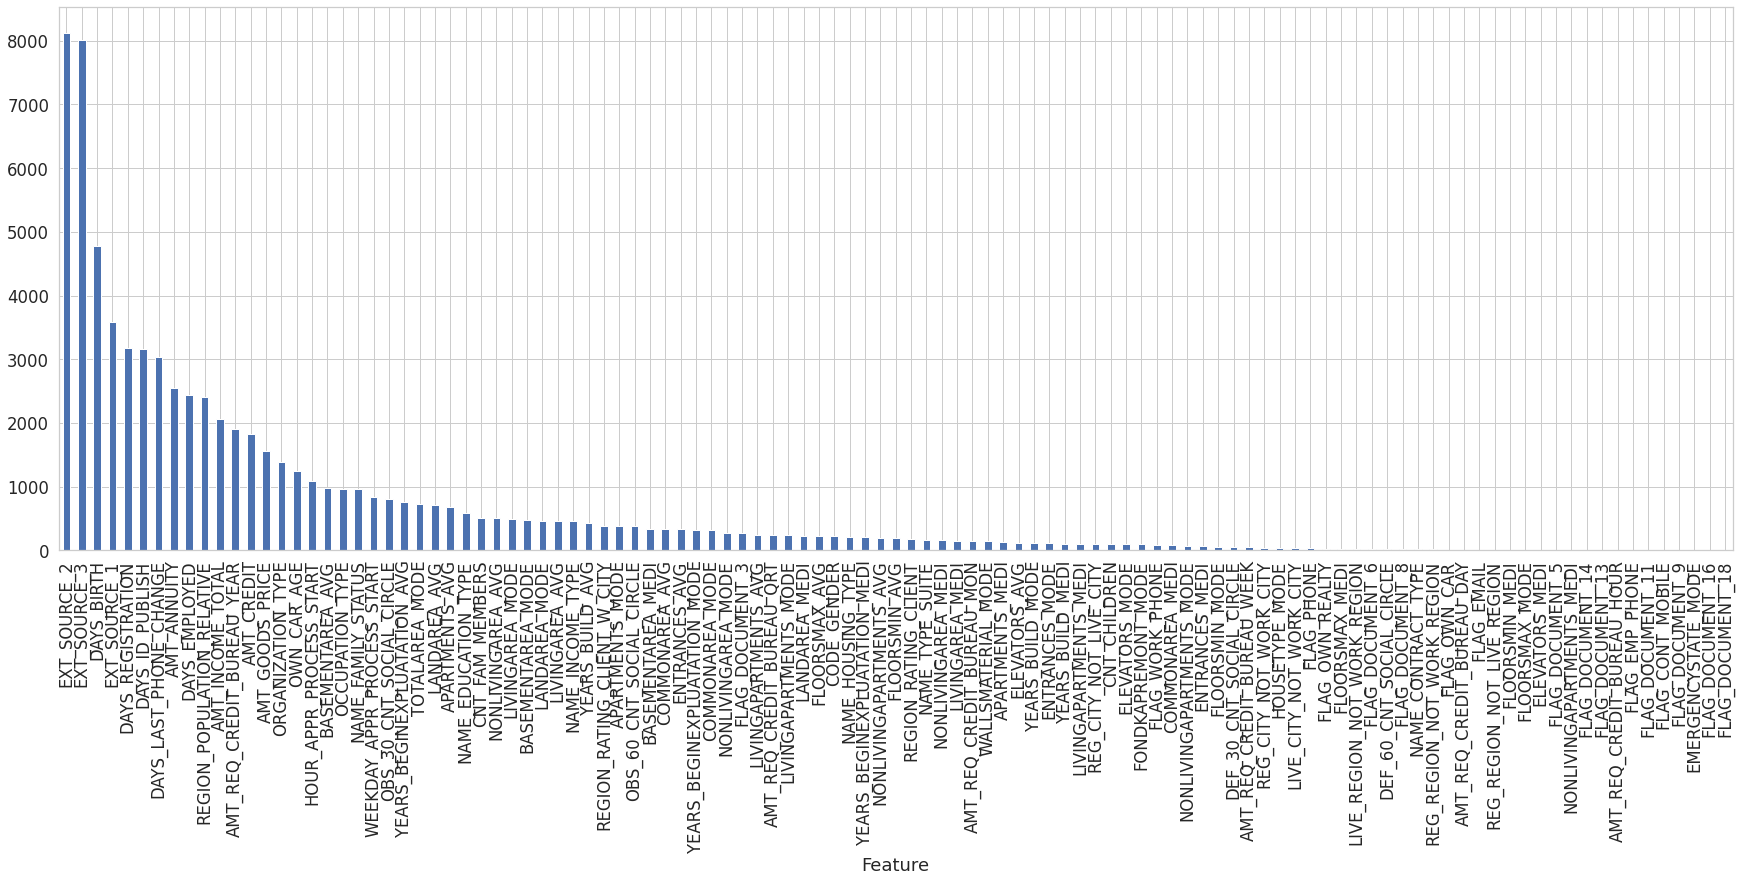

In [13]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [17]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', te_data, silent = False)

LightAutoML used 109 feats
1/109 Calculated score for NONLIVINGAPARTMENTS_AVG: -0.0001189
2/109 Calculated score for LIVE_CITY_NOT_WORK_CITY: 0.0000306
3/109 Calculated score for APARTMENTS_MEDI: -0.0004687
4/109 Calculated score for FLAG_DOCUMENT_16: -0.0010224
5/109 Calculated score for YEARS_BUILD_MODE: -0.0003193
6/109 Calculated score for FLAG_CONT_MOBILE: -0.0011821
7/109 Calculated score for CODE_GENDER: 0.0018240
8/109 Calculated score for FLAG_DOCUMENT_11: -0.0000102
9/109 Calculated score for FLAG_DOCUMENT_6: -0.0000951
10/109 Calculated score for WEEKDAY_APPR_PROCESS_START: 0.0024253
11/109 Calculated score for NAME_HOUSING_TYPE: 0.0018716
12/109 Calculated score for LIVINGAREA_MODE: -0.0003635
13/109 Calculated score for AMT_REQ_CREDIT_BUREAU_WEEK: 0.0001868
14/109 Calculated score for DAYS_ID_PUBLISH: 0.0008560
15/109 Calculated score for EXT_SOURCE_1: 0.0038995
16/109 Calculated score for ORGANIZATION_TYPE: -0.0015115
17/109 Calculated score for FLAG_EMP_PHONE: 0.0000883


<AxesSubplot:xlabel='Feature'>

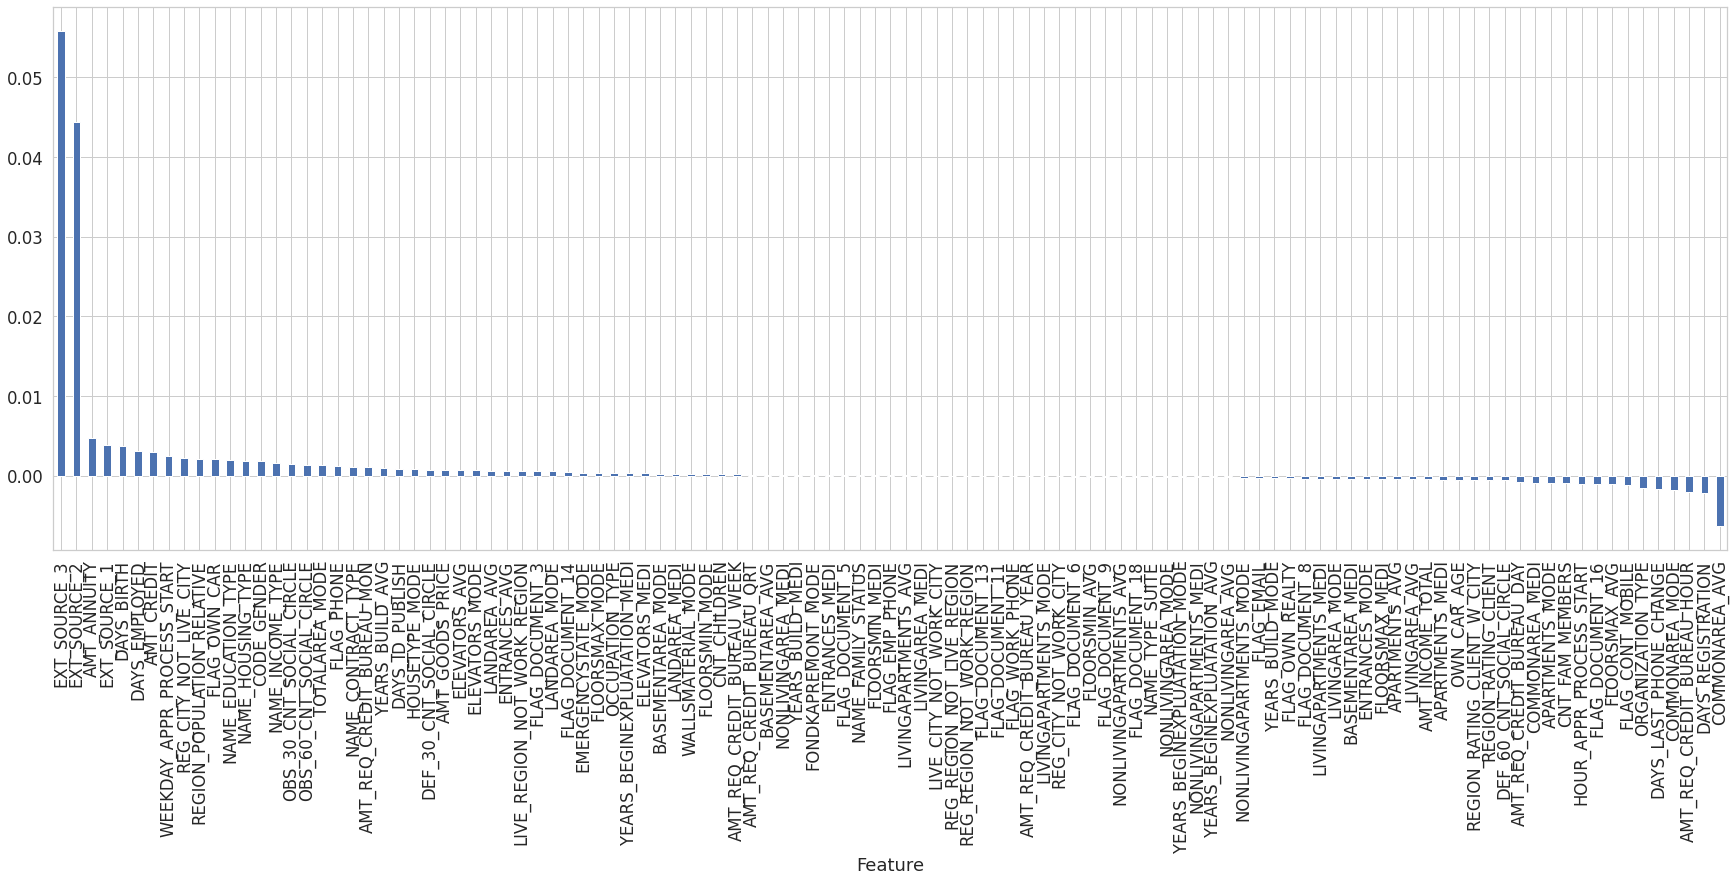

In [18]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# Step 5. Prediction on holdout and metric calculation

In [19]:
%%time

te_pred = automl_rd.predict(te_data)
print('Prediction for te_data:\n{}\nShape = {}'
              .format(te_pred, te_pred.shape))

Prediction for te_data:
array([[0.06215836],
       [0.08295041],
       [0.02322026],
       ...,
       [0.04760616],
       [0.03207987],
       [0.22834152]], dtype=float32)
Shape = (2000, 1)
CPU times: user 2.33 s, sys: 52.5 ms, total: 2.38 s
Wall time: 1.75 s


In [20]:
print('Check scores...')
print('OOF score: {}'.format(roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])))
print('HOLDOUT score: {}'.format(roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])))

Check scores...
OOF score: 0.7539060382309252
HOLDOUT score: 0.7309612771739131


# Bonus. Where is the automatic report?

As we used `automl_rd` in our training and prediction cells, it is already ready in the folder we specified - you can check the output kaggle folder and find the `tabularAutoML_model_report` folder with `lama_interactive_report.html` report inside (or just [click this link](tabularAutoML_model_report/lama_interactive_report.html) for short). It's interactive so you can click the black triangles on the left of the texts to go deeper in selected part.

# Step 6. Spending more from TIMEOUT - `TabularUtilizedAutoML` usage

Using `TabularAutoML` we spent only 31 second to build the model with setup `TIMEOUT` equal to 5 minutes. To spend (almost) all the `TIMEOUT` we can use `TabularUtilizedAutoML` preset instead of `TabularAutoML`, which has the same API:

In [22]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                               timeout = TIMEOUT,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                               general_params={'use_algos': [['linear_l2', 'lgb']]}
                              )

oof_pred = automl.fit_predict(tr_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 42}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 299.99721336364746 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (8000, 122)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 295.60128450393677 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6860710639275996
Linear model: C = 5e-05 score = 0.7048821035863387
Linear model: C = 0.0001 score = 0.7227576695479256
Linear model: C = 0.0005 score = 0.755386992104602
Linear model: C = 

Linear model: C = 0.0001 score = 0.7008109714673915
Linear model: C = 0.0005 score = 0.7345766813858694
Linear model: C = 0.001 score = 0.7433922809103262
Linear model: C = 0.005 score = 0.7500053074048914
Linear model: C = 0.01 score = 0.7490340523097827
Linear model: C = 0.05 score = 0.7442043138586957
Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
Time left 275.5078125
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.720336
[200]	valid's auc: 0.727547
[300]	valid's auc: 0.730701
[400]	valid's auc: 0.73006
[500]	valid's auc: 0.729167
Early stopping, best iteration is:
[324]	valid's auc: 0.731295
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc:

Early stopping, best iteration is:
[378]	valid's auc: 0.763693
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Time left 242.89653038978577
Blending: Optimization starts with equal weights and score 0.7543763084173047
Blending, iter 0: score = 0.755039831587147, weights = [0.38196602 0.618034  ]
Blending, iter 1: score = 0.755039831587147, weights = [0.38196602 0.618034  ]
No score update. Terminated

Automl preset training completed in 17.97 seconds.
Current random state: {'reader_params': {'random_state': 45}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 45}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 242.81151413917542 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (8000

Linear model: C = 0.0001 score = 0.7454833984375
Linear model: C = 0.0005 score = 0.7673764436141304
Linear model: C = 0.001 score = 0.7717497452445652
Linear model: C = 0.005 score = 0.7710385529891304
Linear model: C = 0.01 score = 0.7696878184442935

===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6135890794836956
Linear model: C = 5e-05 score = 0.6383003566576088
Linear model: C = 0.0001 score = 0.6541960343070652
Linear model: C = 0.0005 score = 0.6921758237092391
Linear model: C = 0.001 score = 0.7017556895380433
Linear model: C = 0.005 score = 0.7051789656929348
Linear model: C = 0.01 score = 0.7027694038722826
Linear model: C = 0.05 score = 0.6965278957201088

===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6485489555027174
Linear model: C = 5e-05 score = 0.6689346976902175
Linear model: C = 0.0001 score = 0.680871051290761
Linear model: C = 0.0005 score = 0.7145571

[300]	valid's auc: 0.712827
Early stopping, best iteration is:
[170]	valid's auc: 0.716611

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.767132
[200]	valid's auc: 0.771569
[300]	valid's auc: 0.772551
[400]	valid's auc: 0.772737
Early stopping, best iteration is:
[271]	valid's auc: 0.775136

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738069
[200]	valid's auc: 0.744241
[300]	valid's auc: 0.747766
[400]	valid's auc: 0.750515
[500]	valid's auc: 0.750143
[600]	valid's auc: 0.749703
Early stopping, best iteration is:
[409]	valid's auc: 0.751332
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Time left 186.9527599811554
Blending: Optimization starts with equal weights and score 0.7445644143658612
Blending, iter 0: score = 0.7463379197432478, weights = [0.2906024 0

Linear model: C = 1e-05 score = 0.6650416152156133
Linear model: C = 5e-05 score = 0.6864933634823143
Linear model: C = 0.0001 score = 0.7002501723944384
Linear model: C = 0.0005 score = 0.7256710019190574
Linear model: C = 0.001 score = 0.7306423764239246
Linear model: C = 0.005 score = 0.7304873550683965
Linear model: C = 0.01 score = 0.7273548545739318

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6409567128057065
Linear model: C = 5e-05 score = 0.6581712805706522
Linear model: C = 0.0001 score = 0.6694070567255435
Linear model: C = 0.0005 score = 0.6959653108016305
Linear model: C = 0.001 score = 0.7033372961956522
Linear model: C = 0.005 score = 0.7104757557744565
Linear model: C = 0.01 score = 0.7107411260190217
Linear model: C = 0.05 score = 0.7069516389266305
Linear model: C = 0.1 score = 0.7052744989809782

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6530045

Linear model: C = 0.05 score = 0.7179963485054348
Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
Time left 135.4391098022461
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.745124
[200]	valid's auc: 0.753345
[300]	valid's auc: 0.75357
[400]	valid's auc: 0.754045
[500]	valid's auc: 0.75164
[600]	valid's auc: 0.74963
Early stopping, best iteration is:
[416]	valid's auc: 0.754879
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.777427
[200]	valid's auc: 0.781056
[300]	valid's auc: 0.78335
[400]	valid's auc: 0.785418
[500]	valid's auc: 0.786594
[600]	valid's auc: 0.786616
Early stopping, best iteration is:
[453]	valid's auc: 0.787343

===== Start

Blending, iter 0: score = 0.7477758367439615, weights = [0.40546834 0.59453166]
Blending, iter 1: score = 0.7477758367439615, weights = [0.40546834 0.59453166]
No score update. Terminated

Automl preset training completed in 18.60 seconds.
Current random state: {'reader_params': {'random_state': 52}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 52}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 102.50214004516602 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (8000, 122)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 101.67123937606812 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0

Linear model: C = 1e-05 score = 0.6945827318274457
Linear model: C = 5e-05 score = 0.7073284646739131
Linear model: C = 0.0001 score = 0.716260827105978
Linear model: C = 0.0005 score = 0.7382812500000001
Linear model: C = 0.001 score = 0.7466404127038044
Linear model: C = 0.005 score = 0.7601796025815217
Linear model: C = 0.01 score = 0.7626793902853262
Linear model: C = 0.05 score = 0.7614268427309784
Linear model: C = 0.1 score = 0.7604396654211956

===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6879670516304348
Linear model: C = 5e-05 score = 0.7100246263586956
Linear model: C = 0.0001 score = 0.7205279806385869
Linear model: C = 0.0005 score = 0.7403458305027173
Linear model: C = 0.001 score = 0.7389340608016304
Linear model: C = 0.005 score = 0.730627972146739
Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
Time left 82.59949851036072
Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.739481
[200]	valid's auc: 0.750584
[300]	valid's auc: 0.755047
[400]	valid's auc: 0.756364
[500]	valid's auc: 0.755042
[600]	valid's auc: 0.75613
[700]	valid's auc: 0.758258
[800]	valid's auc: 0.758508
[900]	valid's auc: 0.760222
[1000]	valid's auc: 0.759442
[1100]	valid's auc: 0.758513
Early stopping, best iteration is:
[916]	valid's auc: 0.760514
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Time left 47.05790686607361
Blending: Optimization starts with equal weights and score 0.7499742223055612
Blending, iter 0: score = 0.7502713301651751, weights = [0.39310947 0.60689056]
Blending, iter 1: score = 0.7502713301651751, weights = [0.39310947 0.60689056]
No score update. Terminated

Automl preset training completed in 23.99 seconds.
Current random state: {'reader_params': {'random_state': 55}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combi

Linear model: C = 0.01 score = 0.7311109459918479
Linear model: C = 0.05 score = 0.730362601902174
Linear model: C = 0.1 score = 0.7292162024456522

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6644074813179347
Linear model: C = 5e-05 score = 0.6857804008152174
Linear model: C = 0.0001 score = 0.7003439198369565
Linear model: C = 0.0005 score = 0.7278787364130435
Linear model: C = 0.001 score = 0.7353727921195653
Linear model: C = 0.005 score = 0.7404307489809783
Linear model: C = 0.01 score = 0.7394170346467391
Linear model: C = 0.05 score = 0.7326076341711957

===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6588930876358696
Linear model: C = 5e-05 score = 0.6836149796195652
Linear model: C = 0.0001 score = 0.6989215353260869
Linear model: C = 0.0005 score = 0.732963230298913
Linear model: C = 0.001 score = 0.7370074728260869
Linear model: C = 0.005 score = 0.7280273437

Spent time now is 4 minutes 52 seconds - much closer to 5 minutes. Let's check the feature importances and scores.

# Step 7. Feature importances calculation for `TabularUtilizedAutoML`

CPU times: user 161 ms, sys: 12 ms, total: 173 ms
Wall time: 170 ms


<AxesSubplot:xlabel='Feature'>

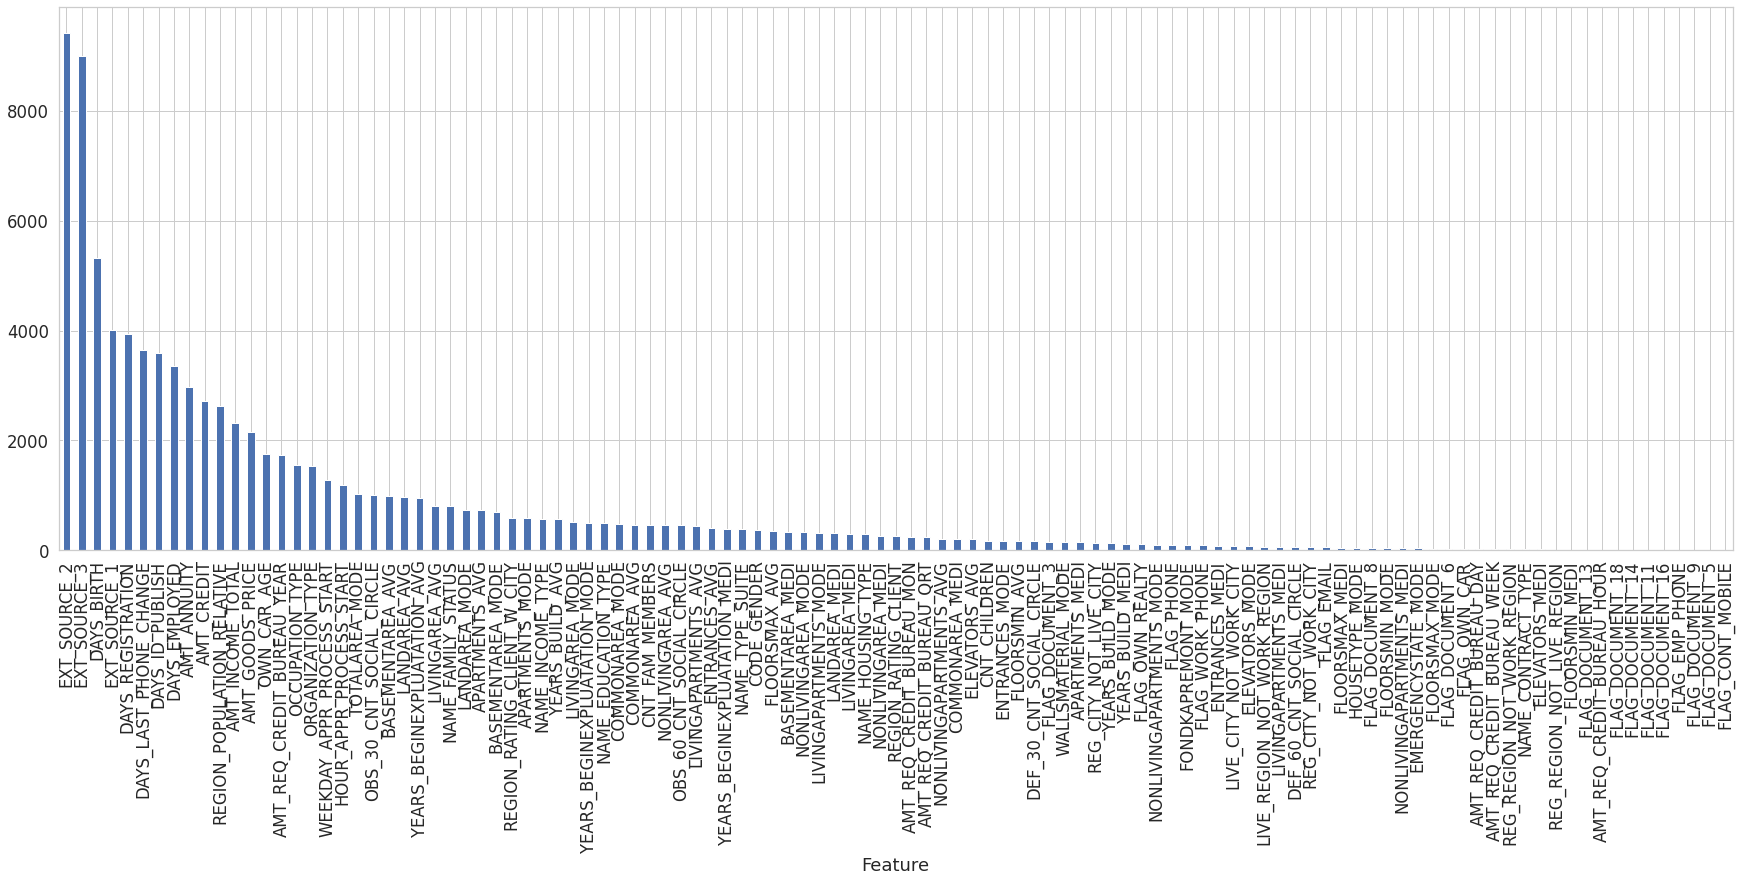

In [23]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# Step 8. Prediction on holdout and metric calculation

In [25]:
%%time

te_pred = automl.predict(te_data)
print('Prediction for te_data:\n{}\nShape = {}'
              .format(te_pred, te_pred.shape))

Prediction for te_data:
array([[0.06655755],
       [0.08908378],
       [0.03262569],
       ...,
       [0.05457988],
       [0.03955465],
       [0.22119653]], dtype=float32)
Shape = (2000, 1)
CPU times: user 5.23 s, sys: 28.3 ms, total: 5.26 s
Wall time: 2.26 s


In [26]:
print('Check scores...')
print('OOF score: {}'.format(roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])))
print('HOLDOUT score: {}'.format(roc_auc_score(te_data[TARGET_NAME].values, te_pred.data[:, 0])))

Check scores...
OOF score: 0.7588068828676445
HOLDOUT score: 0.7336447010869565


# Additional materials

- [Official LightAutoML github repo](https://github.com/sberbank-ai-lab/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)